General notes:
- Data source: https://physionet.org/content/mitdb/1.0.0/
- Docu: https://wfdb.readthedocs.io/en/latest/index.html

In [1]:
#%matplotlib notebook
#%matplotlib qt5

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [16, 8]


import numpy as np
import scipy.stats
import scipy.optimize
import sklearn.decomposition
import sklearn.cluster
import time
import wfdb
from scipy.special import softmax

from collections import Counter
from functools import reduce

In [2]:
# https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
from matplotlib.patches import Ellipse
import matplotlib.transforms
def confidence_ellipse(mu, cov, dims, ax, n_std=3.0, facecolor='none', **kwargs):
    dim0, dim1 = dims

    pearson = cov[dim0, dim1]/np.sqrt(cov[dim0, dim0] * cov[dim1, dim1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[dim0, dim0]) * n_std
    mean_x = mu[dim0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[dim1, dim1]) * n_std
    mean_y = mu[dim1]

    transf = matplotlib.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# First look

In [35]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/100')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/100', 'atr')

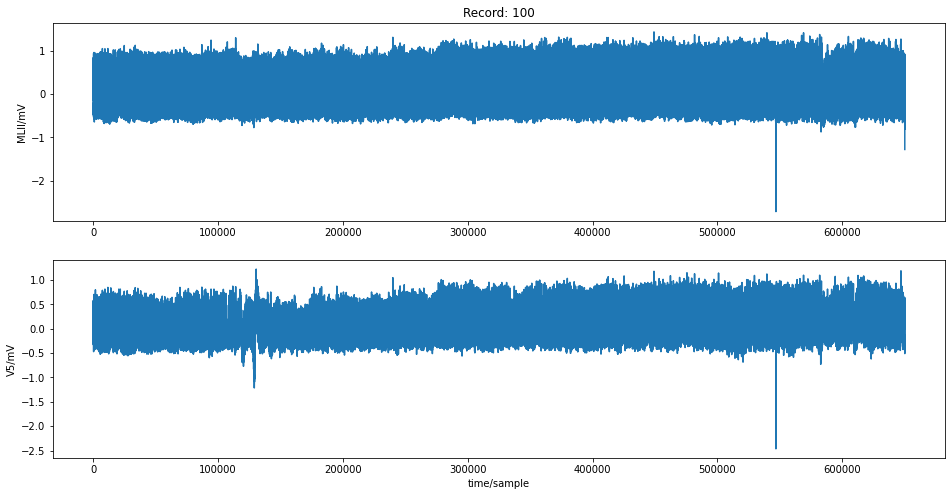

In [36]:
wfdb.plot_wfdb(record=record) 

In [37]:
record.__dict__

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

In [38]:
annotation.__dict__

{'record_name': '100',
 'extension': 'atr',
 'sample': array([    18,     77,    370, ..., 649484, 649734, 649991]),
 'symbol': ['+',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'A',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N',
  'N'

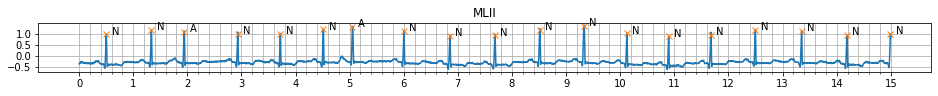

In [110]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/100')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/100', 'atr')

#t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
#t0 = (25*60 + 17) * record.fs  # Premature ventricular contraction
t0 = (26*60 + 11) * record.fs  # Atrial premature beat
dt = 15  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

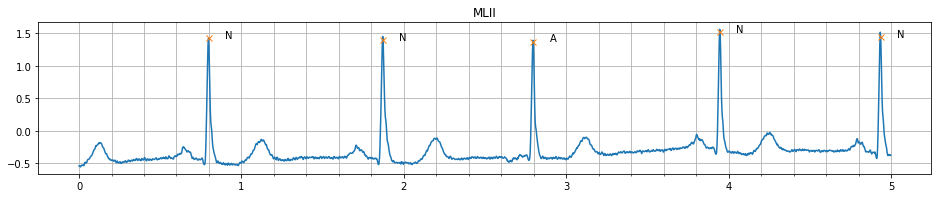

In [41]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/101')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/101', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (1*60 + 51) * record.fs  # Noise
#t0 = (5*60 + 15) * record.fs  # Artifact?
t0 = (9*60 + 56) * record.fs  # Atrial premature beat

dt = 5  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

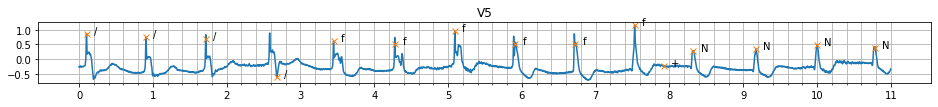

In [42]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/102')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/102', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (1*60 + 13) * record.fs  # Transition from paced to normal sinus rhythm

dt = 11  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

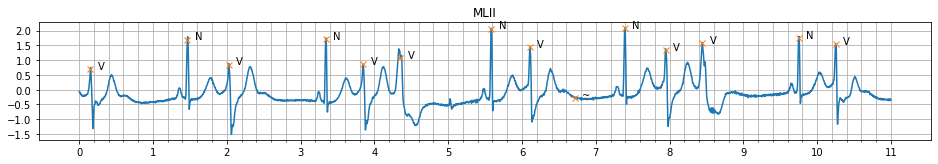

In [43]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/106')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/106', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (0*60 + 19) * record.fs  #0:19 Normal sinus rhythm, noise in lower signal
t0 = (1*60 + 37) * record.fs  #1:37 Ventricular couplets
t0 = (2*60 + 53) * record.fs  #2:53 Ventricular tachycardia, 3 beats
t0 = (4*60 + 23) * record.fs  #4:23 PVC
t0 = (12*60 + 27) * record.fs  #12:27 Ventricular bigeminy (two types)
t0 = (16*60 + 17) * record.fs  #16:17 Multiform PVCs, ventricular couplet
t0 = (25*60 + 13) * record.fs  #25:13 Ventricular couplet
t0 = (25*60 + 52) * record.fs  #25:52 Ventricular couplets

dt = 11  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

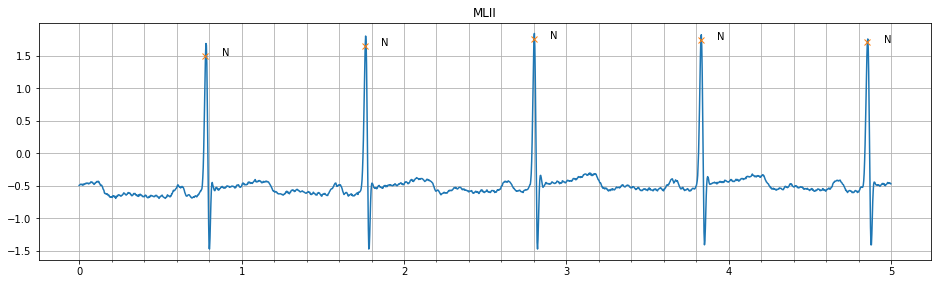

In [44]:
# 115: record with normal beats only (like 122)
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/115')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/115', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (3*60 + 16) * record.fs  #3:22 Sinus arrhythmia ?

dt = 5  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

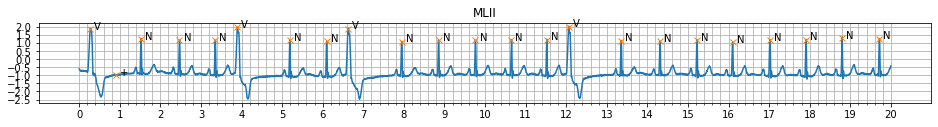

In [45]:
# two types of beats, 1543 normal and 444 PVC
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/119')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/119', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (1*60 + 75) * record.fs  #1:55 PVC

dt = 20  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

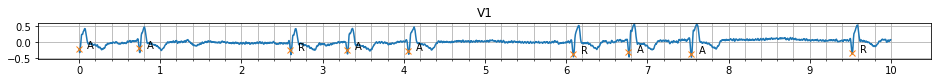

In [336]:
# two types of beats, 1543 normal and 444 PVC
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/232')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/232', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (24*60 + 0) * record.fs
t0 = 291413

dt = 10  # in seconds

channel = 1

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

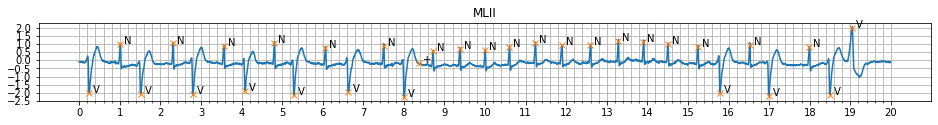

In [366]:
# two types of beats, 1543 normal and 444 PVC
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/200')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/200', 'atr')

t0 = int(0.2 * record.sig_len)  # select timepoint by ratio of time passed

# points of interest, 
# see file:///home/arne/Code/functional_data_hmm/data/MIT_BIH_Arrhythmia_Database/mitdbdir/records.htm
t0 = (15*60 + 58) * record.fs
t0 = 600

dt = 20  # in seconds

channel = 0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = np.logical_and(annotation.sample >= t0, annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = np.asarray(annotation.symbol, dtype=object)[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

Christoph fragen:
- Ganz allgemein: Was sind die wichtigen points of interest wo du zuerst drauf guckst?
- Spiel außer der Form eigentlich sowas wie amplitude und y-Verschiebung und Trend/Drift oder wie das heißt eine Rolle?
- - Antwort: y-Verschiebung spielt keine Rolle, amplitude evtl schon
- Wie zerschneided man die am besten, was ist eine Einheit? Am einfachsten wäre R bis R, aber wahrscheinlich würde es mehr Sinn machen zwischen T und P zu trennen und dann R zu allignen? Erstens weil Menschen so über das Ding nachdenken, zweitens weil man dann nicht den Teil mit der meisten Struktur (QRS) am Rand des Intervals hat, das ist für functional data analysis schlecht. Wie ist es denn wenn man von einem Rythmus in den Anderen wechselt, kann das an einer beliebigen Stelle passieren oder ist das zB tendenziell immer zwischen T und P?
- - Die Semantisch logische Einheit wäre von P bis T, also zwischen T und P trennen, das wird aber schwierig automatisiert
- MLII: modified limb lead II? Ist das "Lead II is the voltage between the (positive) left leg (LL) electrode and the right arm (RA) electrode" (Wiki)?
- - Ja


# Cut the data into beats

In [46]:
record_nr = 115
#record_nr = 122
#record_nr = 119
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[np.logical_or(symbols == 'N', symbols == 'V')]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])
min_data_len = min(cuts[1:] - cuts[:-1])
print('Nr of curves:', len(cuts) - 1)
print('Longest curve:', max_data_len)
print('Shortest curve:', min_data_len)

Nr of curves: 1952
Longest curve: 471
Shortest curve: 252


In [47]:
set(annotation.symbol) # N: Normal beat

{'+', 'N', '|', '~'}

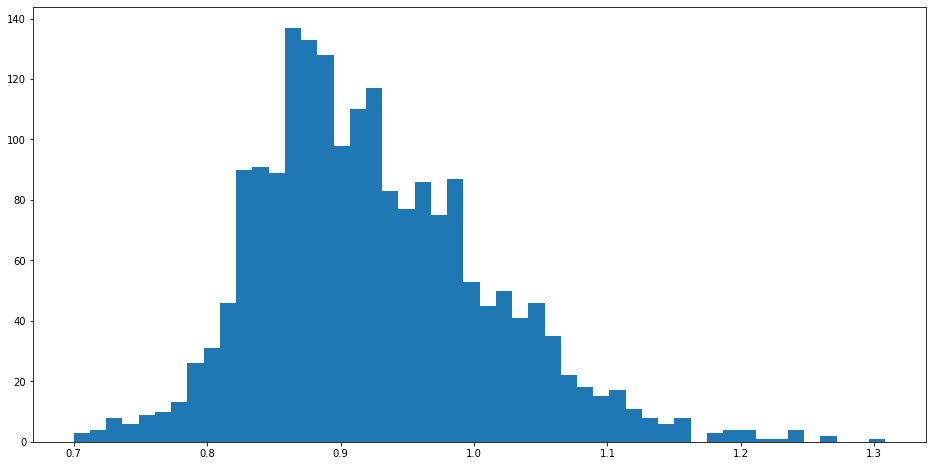

In [48]:
# Distribution of beat leangths
plt.hist(periods, bins=50)
pass

In [49]:
data = np.array([
    np.append(
        record.p_signal[cuts[i]:cuts[i+1], 0], 
        np.repeat(np.nan, max_data_len - (cuts[i+1] - cuts[i]))
    )
    for i in range(len(cuts)-1)
])

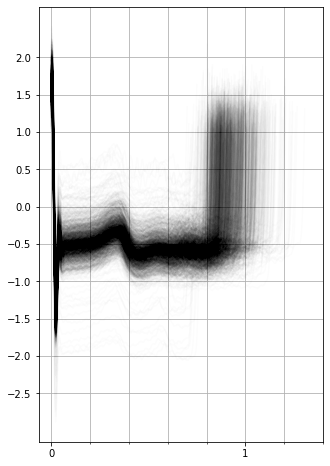

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

t = np.arange(0, max_data_len) / record.fs
ax.plot(t, data.transpose(), color='black', alpha=0.01)

dt = max_data_len/record.fs
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(-2.5, 2.5, 0.5))
ax.grid(which='both')
ax.set_box_aspect(5/dt * 0.2/0.5)
pass

## Stretch to [0,1] and vertical align

In [51]:
# upsampling might be a bad idea if max_data_len is much longer than the average length of the cluster of shortest
# beats, might create 
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])

In [52]:
# todo: better than this beatwise vertical align would be removal of baseline wandering in the full 30min data
# see https://dss.tf.uni-kiel.de/index.php/teaching/red-main/red-trend-removal
# see https://pubmed.ncbi.nlm.nih.gov/26405865/

data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align

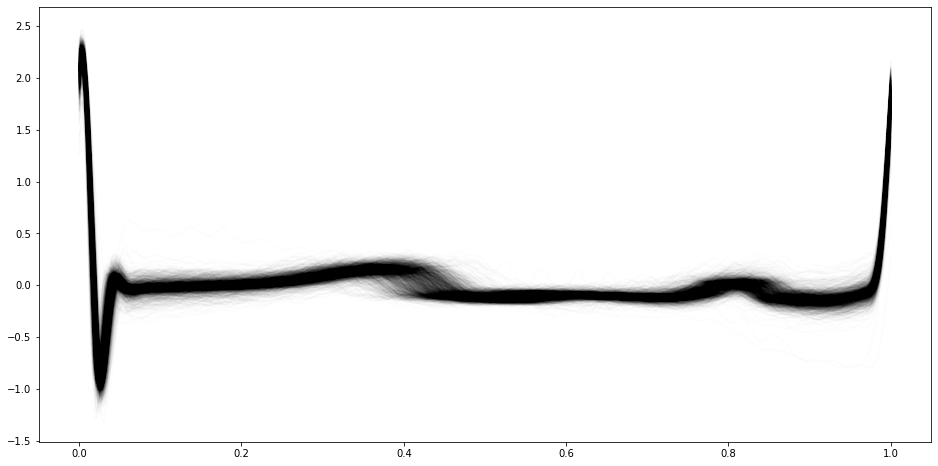

In [53]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, data.transpose(), color='black', alpha=0.01)
pass

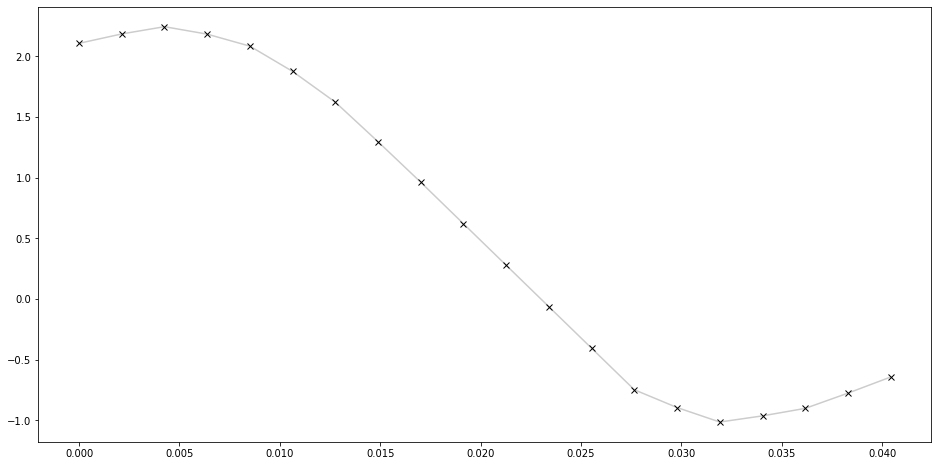

In [54]:
# when the longest and the shortest period are very different (the longest is c times the shortest)
# and we do linear upsampling to the length of the longest, this might results in the shortest curve becoming 
# piecewise linear with pieces of length ceil(c)
# When I do a basis function decomposition, I should do that on the original, nun-upsampled data

t = np.linspace(0, 1, data.shape[1])
plt.plot(t[:20], data[periods.argmin(),:20], color='black', alpha=0.2)
plt.plot(t[:20], data[periods.argmin(),:20], 'x', color='black')
pass

## Summary statistics

In [55]:
mean = data.mean(axis=0)
cov = np.cov((data - mean).transpose())
var = cov.diagonal()
corr = cov / np.sqrt(np.outer(var, var))

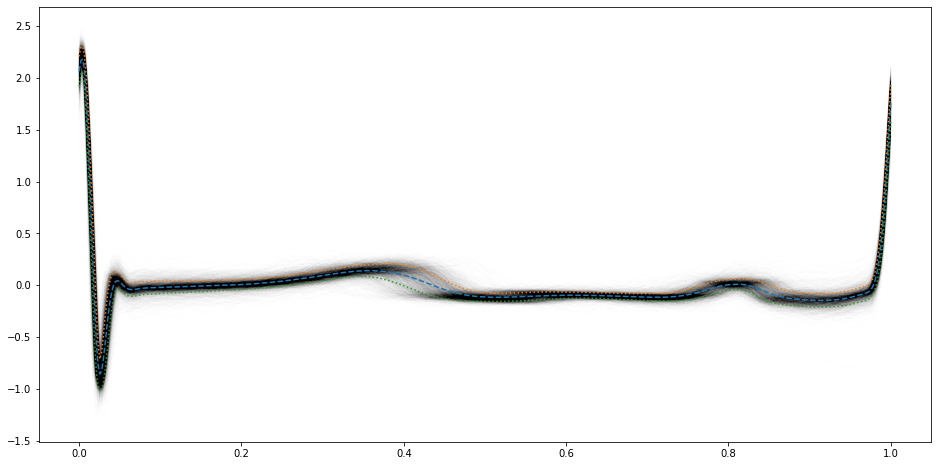

In [56]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, data.transpose(), color='black', alpha=0.005)
plt.plot(t, mean, '--')
plt.plot(t, mean+np.sqrt(var), ':')
plt.plot(t, mean-np.sqrt(var), ':')
pass

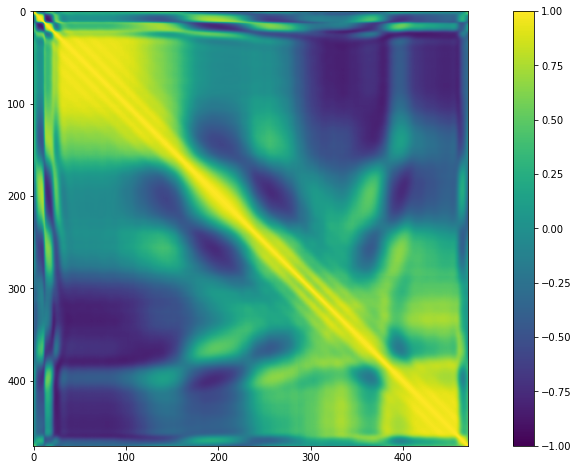

In [57]:
plt.imshow(corr, norm=colors.Normalize(vmin=-1, vmax=1))
plt.colorbar()
pass

# PCA

## Example with one cluster

In [58]:
record_nr = 115
#record_nr = 122
#record_nr = 119

record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[np.logical_or(symbols == 'N', symbols == 'V')]
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align
mean = data.mean(axis=0)

In [59]:
x = data - mean

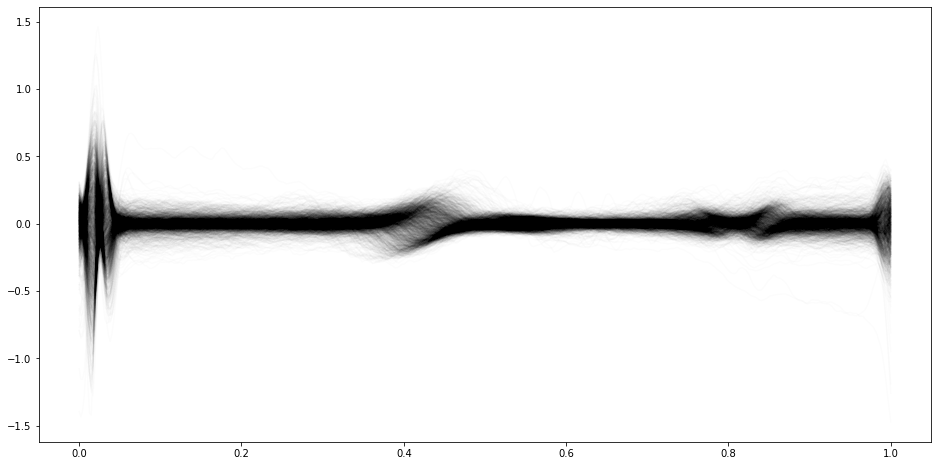

In [60]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, x.transpose(), color='black', alpha=0.01)
pass

In [61]:
pca = sklearn.decomposition.PCA()
x_transformed = pca.fit_transform(x)

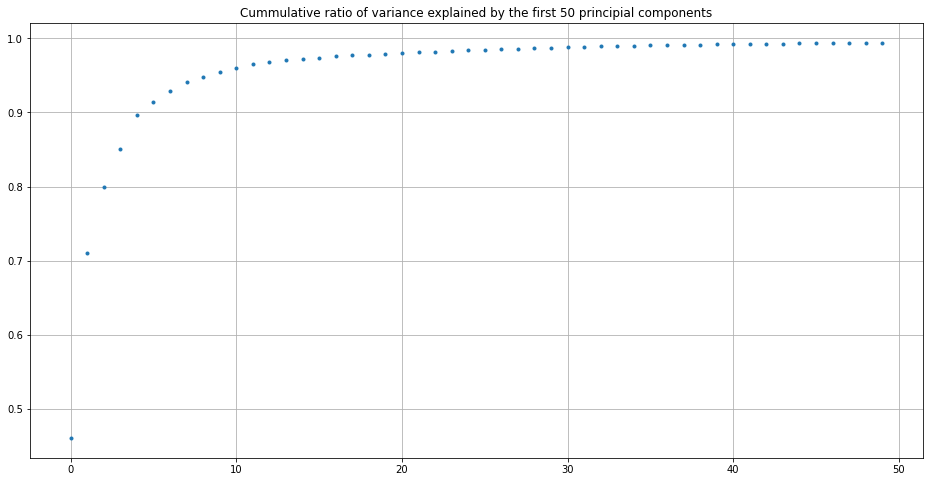

In [62]:
plt.plot(pca.explained_variance_ratio_.cumsum()[:50], '.')
plt.grid()
plt.title('Cummulative ratio of variance explained by the first 50 principial components')
pass

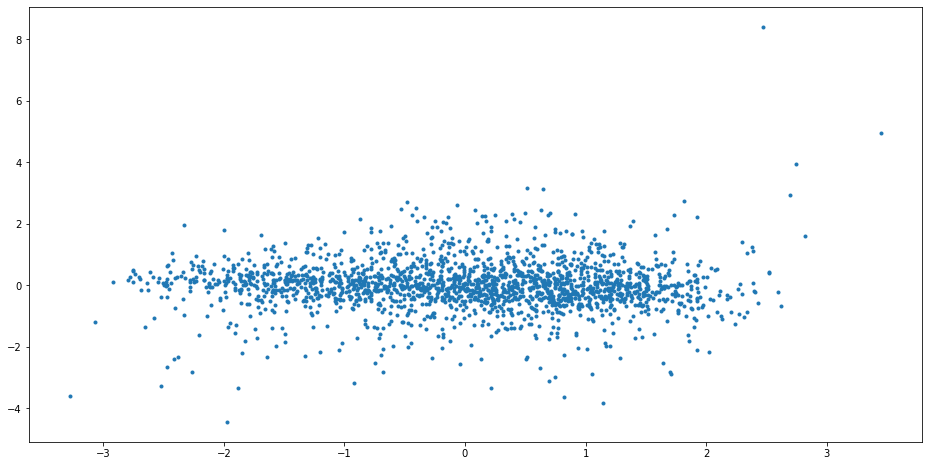

In [63]:
plt.plot(x_transformed[:, 0], x_transformed[:, 1], '.')

0.46037817190052205


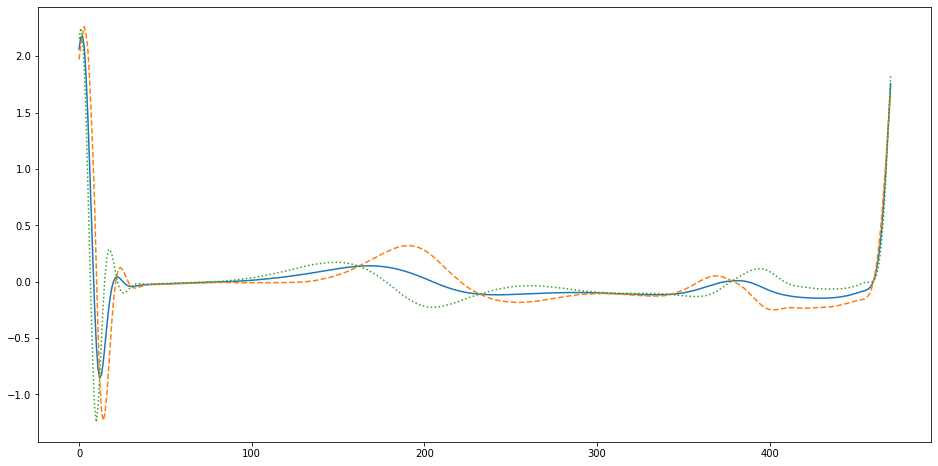

In [64]:
plt.plot(mean)
plt.plot(mean + 3 * pca.components_[0,], '--')
plt.plot(mean - 3 * pca.components_[0,], ':')
print(pca.explained_variance_ratio_[0])

0.2497080502666588


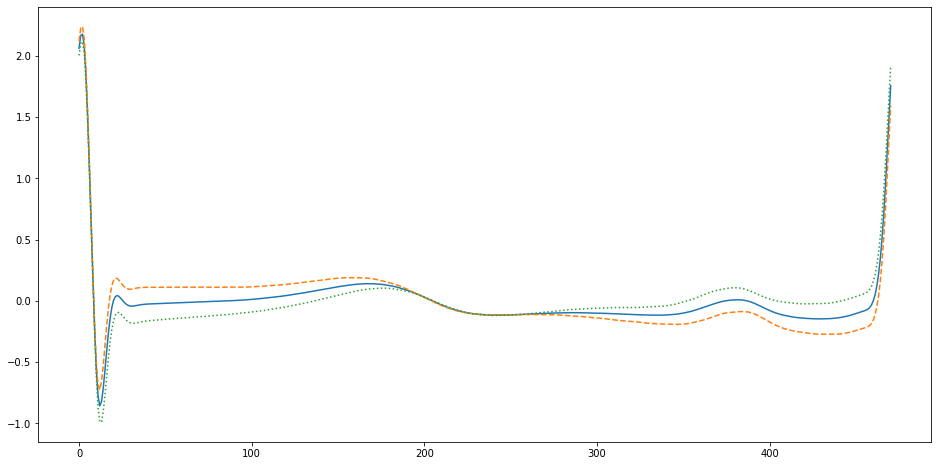

In [65]:
plt.plot(mean)
plt.plot(mean + 2 * pca.components_[1,], '--')
plt.plot(mean - 2 * pca.components_[1,], ':')
print(pca.explained_variance_ratio_[1])

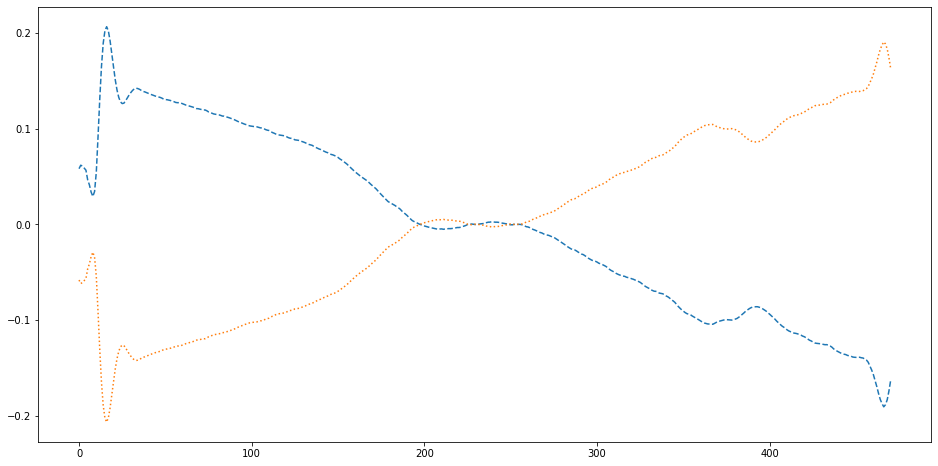

In [68]:
# this is mainly just baseline wandering
plt.plot(+ 2 * pca.components_[1,], '--')
plt.plot(- 2 * pca.components_[1,], ':')

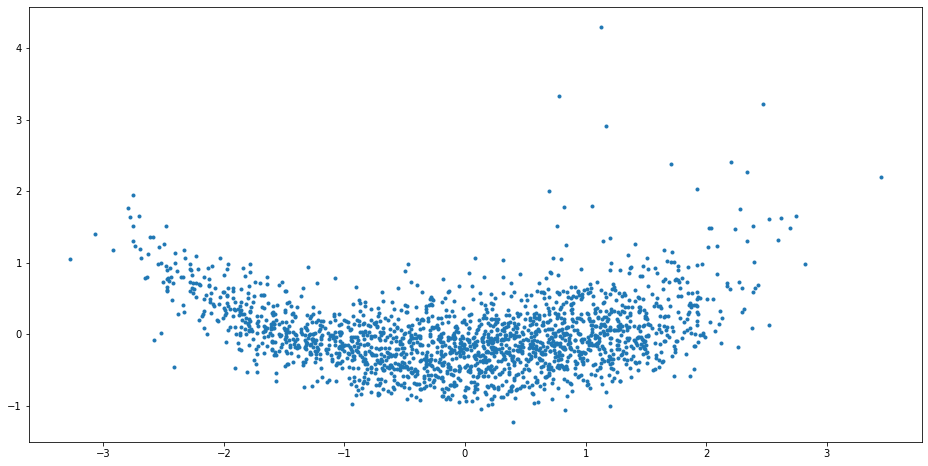

In [69]:
# zwischen dimension 1 und 3 gibt es scheinbar eine quadratische abhängigkeit 
plt.plot(x_transformed[:, 0], x_transformed[:, 2], '.')

0.08921594080796191


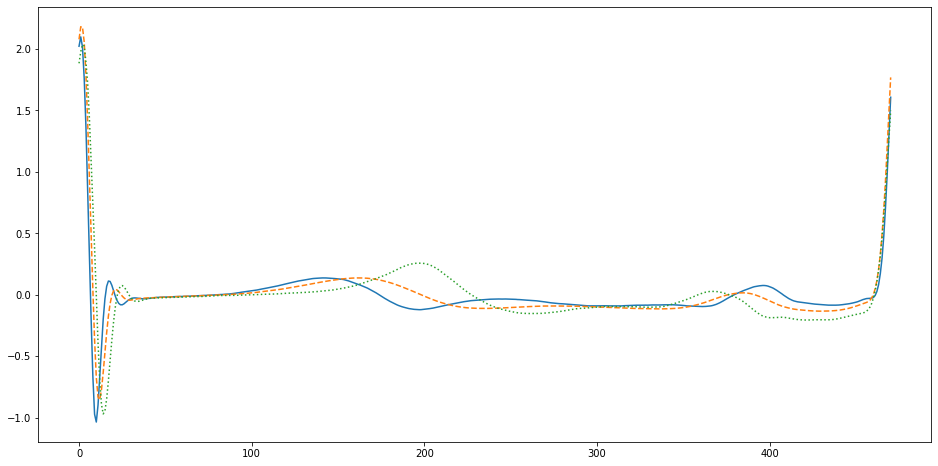

In [70]:
plt.plot(mean - 2.5 * pca.components_[0,] + 1 * pca.components_[2,])
plt.plot(mean - 0.5 * pca.components_[0,] + 0 * pca.components_[2,], '--')
plt.plot(mean +   2 * pca.components_[0,] + 1 * pca.components_[2,], ':')
print(pca.explained_variance_ratio_[2])

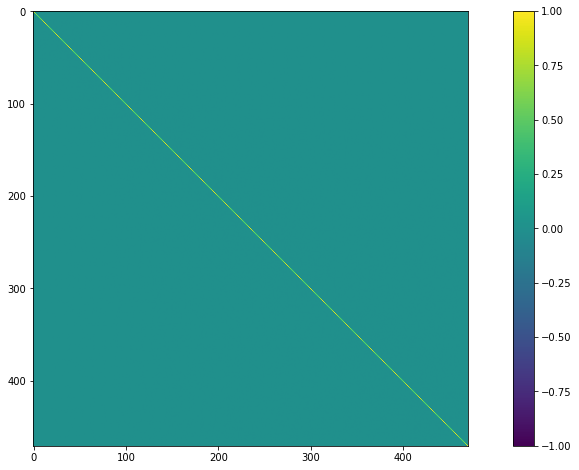

In [71]:
cov = np.cov(x_transformed.transpose())
var = cov.diagonal()
corr = cov / np.sqrt(np.outer(var, var))
plt.imshow(corr, norm=colors.Normalize(vmin=-1, vmax=1))
plt.colorbar()
pass

## example with two different beats

In [74]:
#record_nr = 115
#record_nr = 122
record_nr = 119

record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[np.logical_or(symbols == 'N', symbols == 'V')]
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align
mean = data.mean(axis=0)
x = data - mean

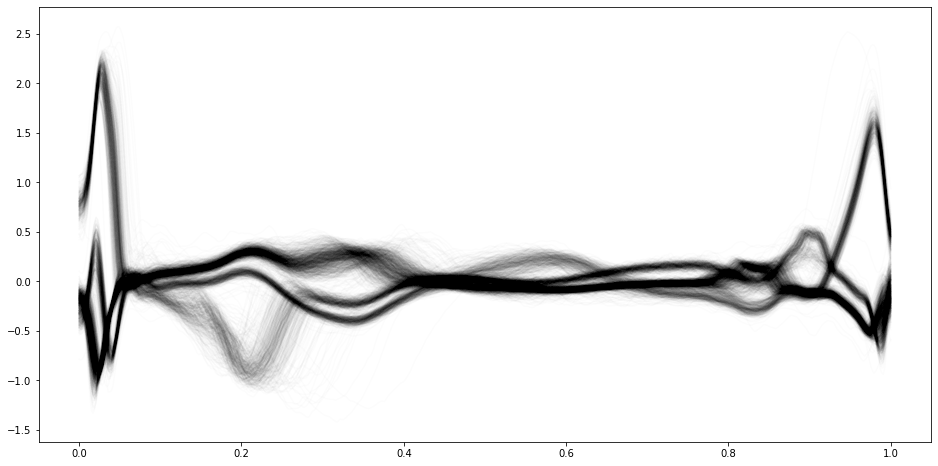

In [75]:
t = np.linspace(0, 1, data.shape[1])
plt.plot(t, x.transpose(), color='black', alpha=0.01)
pass

In [76]:
pca = sklearn.decomposition.PCA()
x_transformed = pca.fit_transform(x)

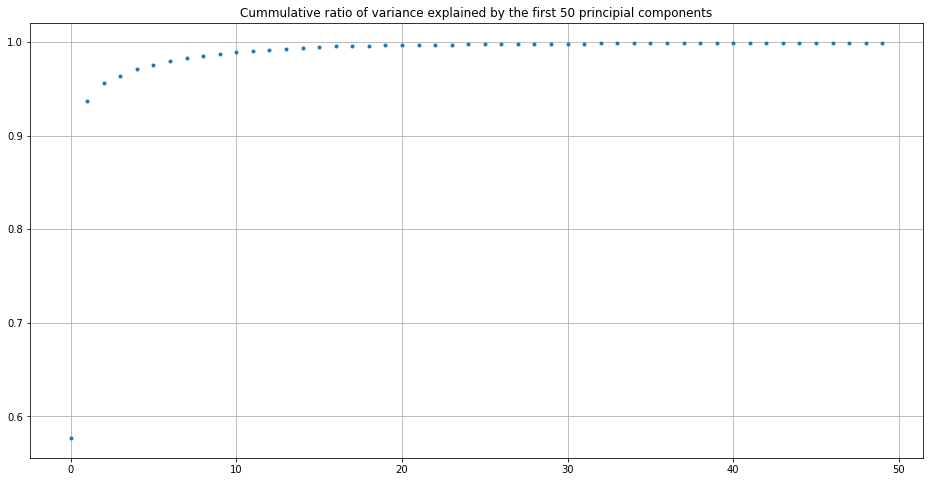

In [77]:
plt.plot(pca.explained_variance_ratio_.cumsum()[:50], '.')
plt.grid()
plt.title('Cummulative ratio of variance explained by the first 50 principial components')
pass

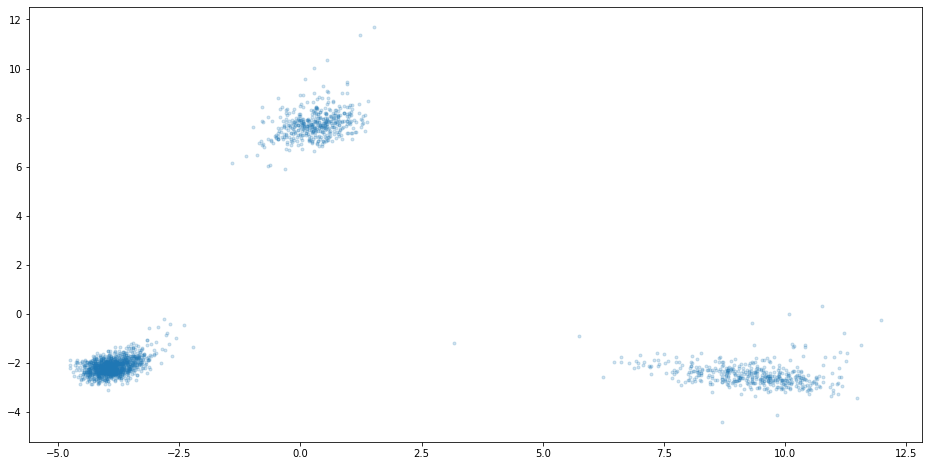

In [78]:
# nothing at 0 -> mean is not actually in the data
plt.plot(x_transformed[:, 0], x_transformed[:, 1], '.', alpha=0.2)

0.5767715554656614


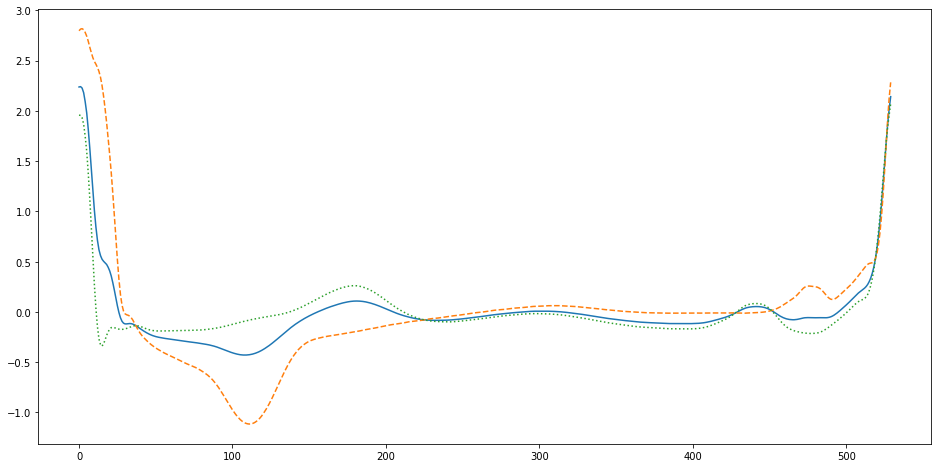

In [79]:
plt.plot(mean)
plt.plot(mean + 8 * pca.components_[0,], '--')
plt.plot(mean - 4 * pca.components_[0,], ':')
print(pca.explained_variance_ratio_[0])

0.360052121454059


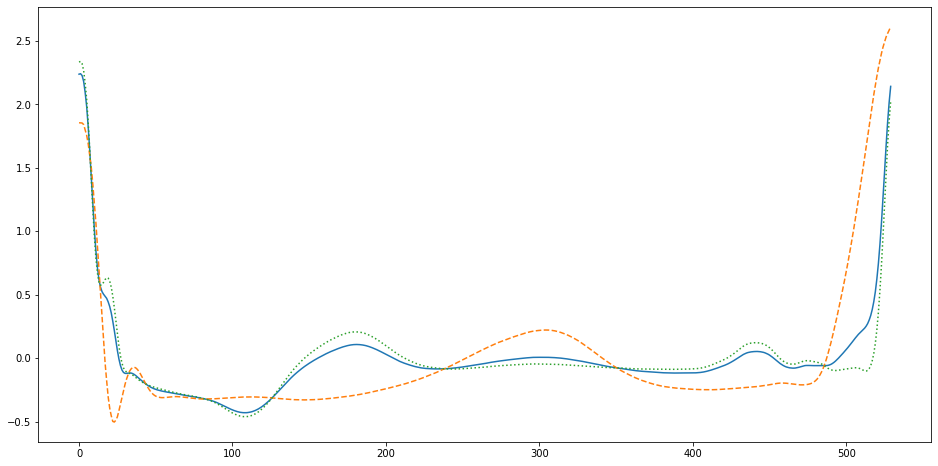

In [80]:
plt.plot(mean)
plt.plot(mean + 8 * pca.components_[1,], '--')
plt.plot(mean - 2 * pca.components_[1,], ':')
print(pca.explained_variance_ratio_[1])

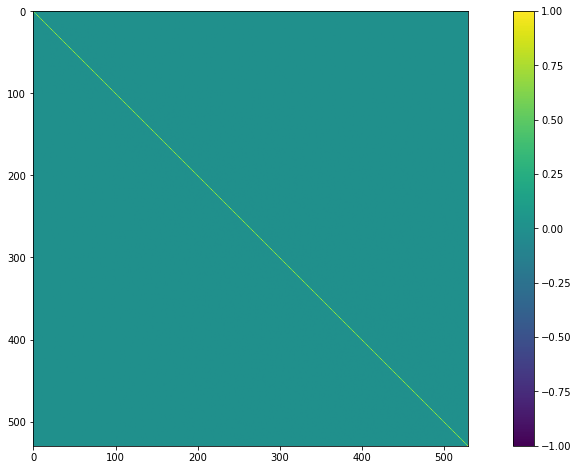

In [81]:
cov = np.cov(x_transformed.transpose())
var = cov.diagonal()
corr = cov / np.sqrt(np.outer(var, var))
plt.imshow(corr, norm=colors.Normalize(vmin=-1, vmax=1))
plt.colorbar()
pass

# k-means

In [82]:
#record_nr = 115
#record_nr = 122
record_nr = 119

record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[np.logical_or(symbols == 'N', symbols == 'V')]
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align
mean = data.mean(axis=0)
x = data - mean

In [83]:
kmeans = sklearn.cluster.KMeans(3).fit(x)

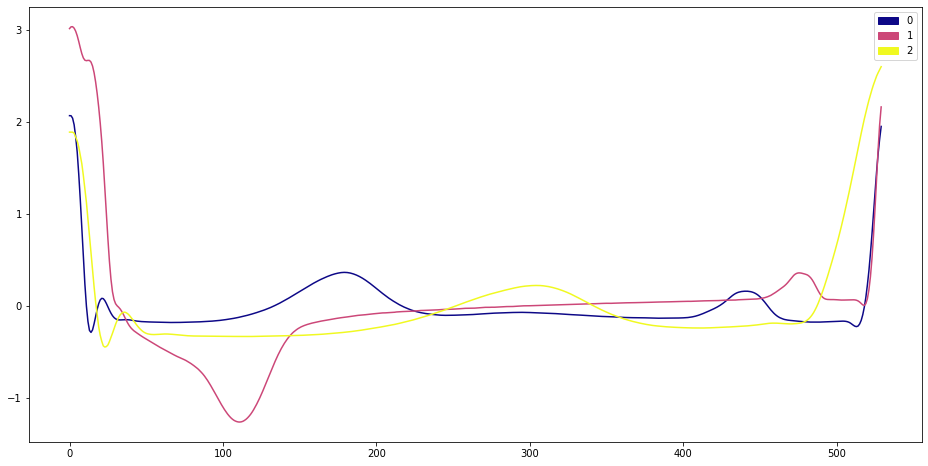

In [84]:
cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
for c in range(kmeans.n_clusters):
    plt.plot(kmeans.cluster_centers_[c] + mean, color=cmap(c))
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))
pass

## with PCA

In [85]:
pca = sklearn.decomposition.PCA(10)
x_transformed = pca.fit_transform(x)
kmeans = sklearn.cluster.KMeans(3).fit(x_transformed)

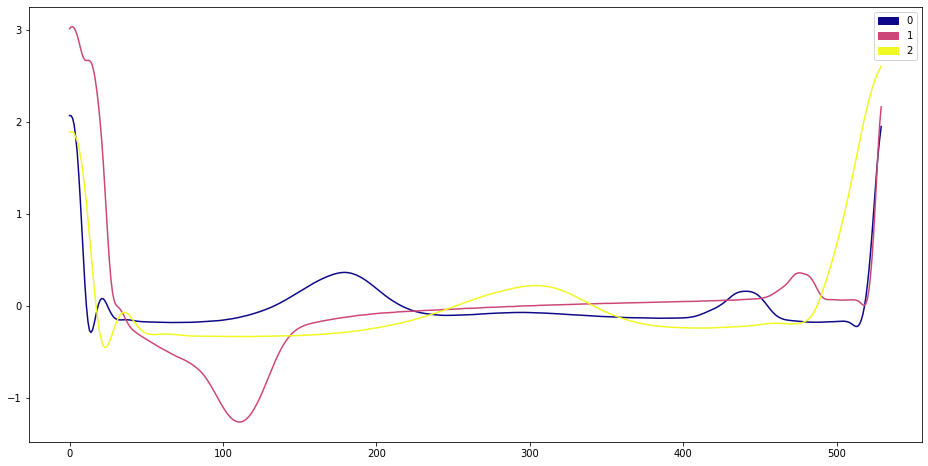

In [86]:
cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
for c in range(kmeans.n_clusters):
    plt.plot(np.matmul(kmeans.cluster_centers_, pca.components_)[c] + mean, color=cmap(c))
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))
pass

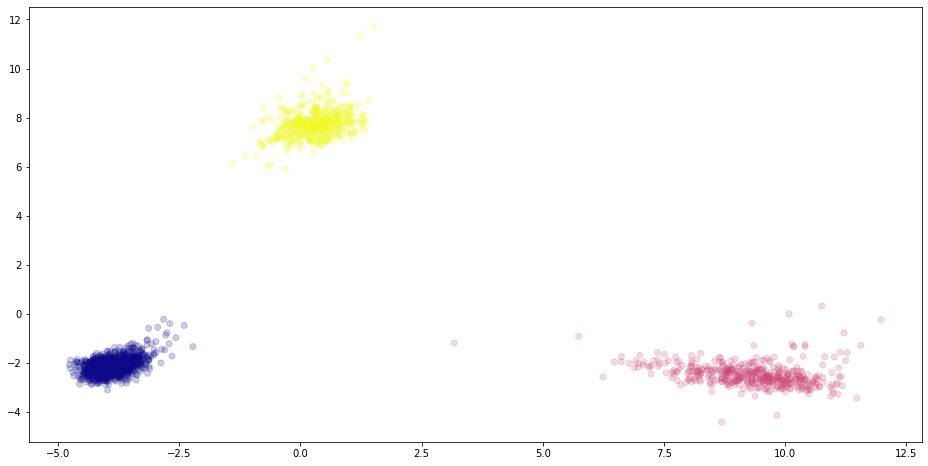

In [87]:
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], alpha=0.2, c=kmeans.labels_, cmap=cmap)

## Period length of the clusters

In [88]:
periods = (cuts[1:] - cuts[:-1]) / record.fs

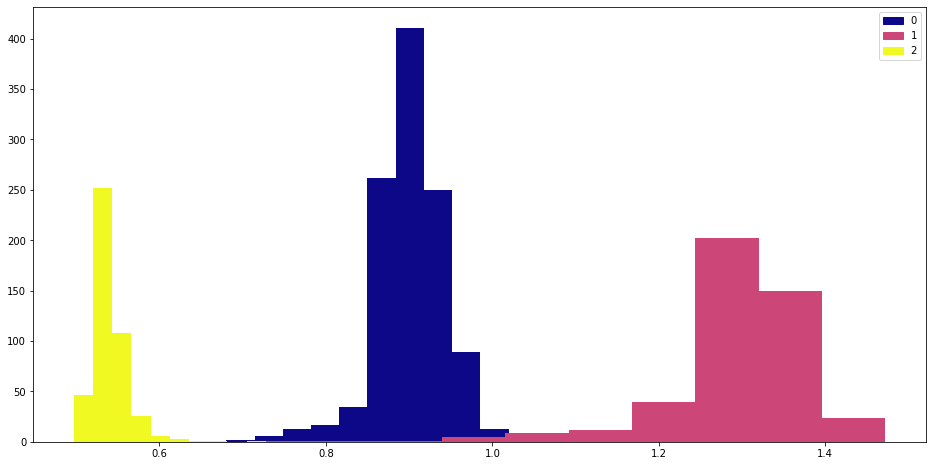

In [89]:
cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
plt.hist(periods[kmeans.labels_ == 0], color=cmap(0))
plt.hist(periods[kmeans.labels_ == 1], color=cmap(1))
plt.hist(periods[kmeans.labels_ == 2], color=cmap(2))
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))
pass

## Try 4 clusters

In [90]:
kmeans = sklearn.cluster.KMeans(4).fit(x_transformed)

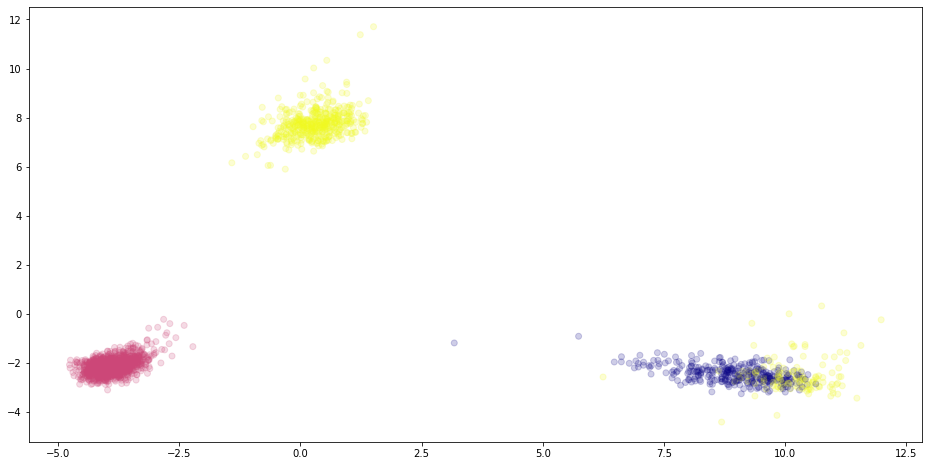

In [91]:
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], alpha=0.2, c=kmeans.labels_, cmap=cmap)

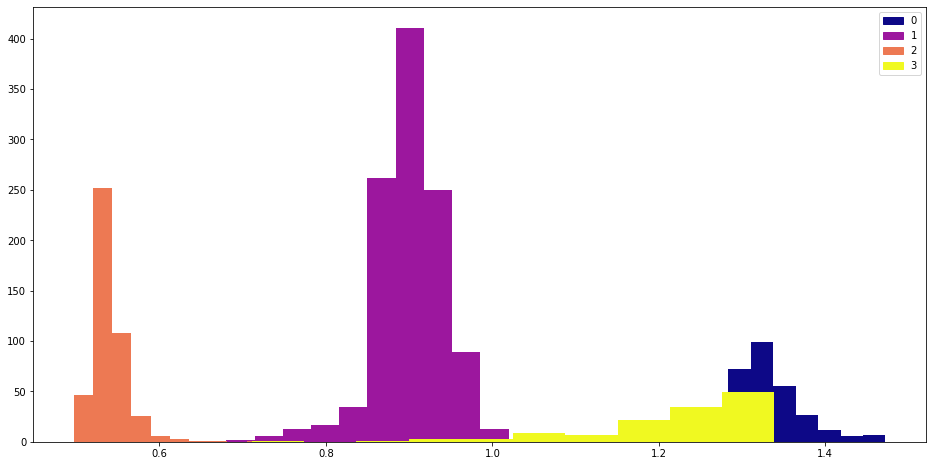

In [92]:
periods = (cuts[1:] - cuts[:-1]) / record.fs
cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
plt.hist(periods[kmeans.labels_ == 0], color=cmap(0))
plt.hist(periods[kmeans.labels_ == 1], color=cmap(1))
plt.hist(periods[kmeans.labels_ == 2], color=cmap(2))
plt.hist(periods[kmeans.labels_ == 3], color=cmap(3))
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))
pass

## Markov chain

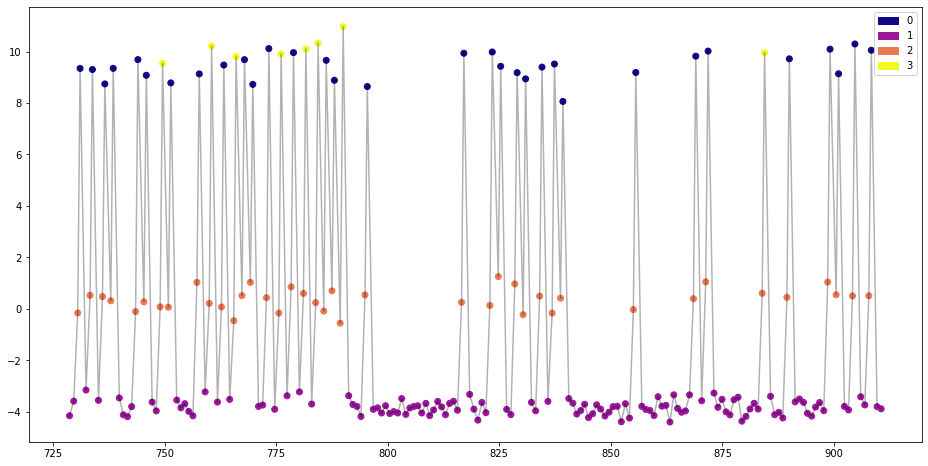

In [93]:
start, stop = 400, 700
start, stop = 800, 1000

cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
plt.plot(cuts[:-1][start:stop]/record.fs, x_transformed[:,0][start:stop], color='black', alpha=0.3)
plt.scatter(
    cuts[:-1][start:stop]/record.fs, 
    x_transformed[:,0][start:stop], 
    c=kmeans.labels_[start:stop],
    cmap=cmap
)
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))

In [95]:
transitions = zip(kmeans.labels_[:-1], kmeans.labels_[1:])
transition_count = Counter(transitions)
a = np.array([[transition_count[(i,j)] for j in range(kmeans.n_clusters)] for i in range(kmeans.n_clusters)])
print('distribution of classes in the data:', a.sum(axis=1) / a.sum())
a = a / a.sum(axis=1)[:, np.newaxis]
stat = np.linalg.solve(
    (np.eye(kmeans.n_clusters) - a + np.ones((kmeans.n_clusters, kmeans.n_clusters))).transpose(), 
    np.ones(kmeans.n_clusters)
)
print('Stationary distribution:', stat)

distribution of classes in the data: [0.1581864  0.55264484 0.22367758 0.06549118]
Stationary distribution: [0.15786799 0.55354531 0.22322734 0.06535936]


array([[0.        , 0.60509554, 0.39490446, 0.        ],
       [0.        , 0.75022789, 0.24977211, 0.        ],
       [0.70720721, 0.        , 0.        , 0.29279279],
       [0.        , 0.65384615, 0.34615385, 0.        ]])

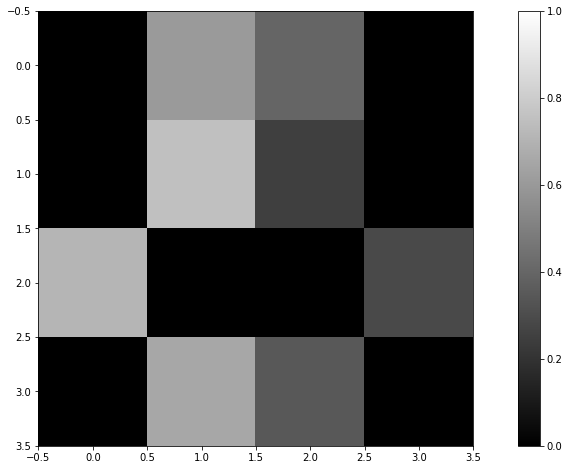

In [96]:
plt.imshow(a, vmin=0, vmax=1, cmap='gray')
plt.colorbar()
a

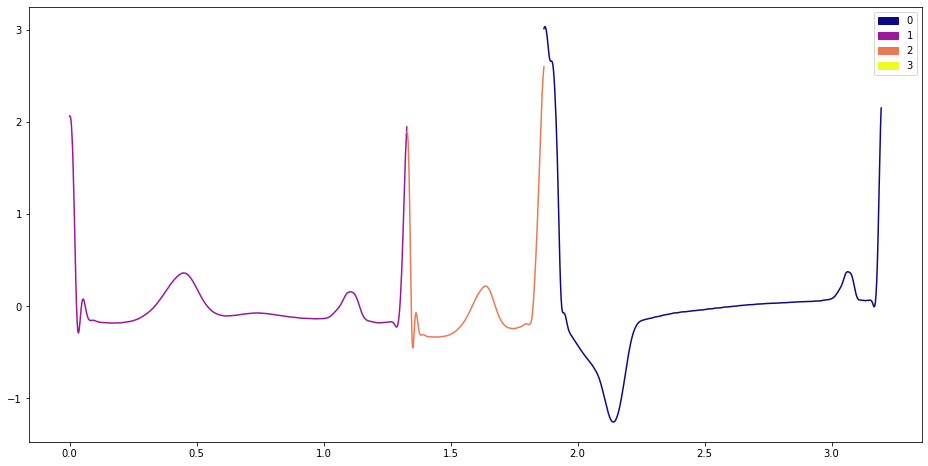

In [97]:
cmap = plt.cm.get_cmap('plasma', kmeans.n_clusters)
t1, t2 = 0, periods[kmeans.labels_ == 0].mean()
plt.plot(
    np.linspace(t1, t2, data.shape[1]),
    np.matmul(kmeans.cluster_centers_, pca.components_)[1] + mean, color=cmap(1)
)
t1, t2 = t2, t2 + periods[kmeans.labels_ == 2].mean()
plt.plot(
    np.linspace(t1, t2, data.shape[1]),
    np.matmul(kmeans.cluster_centers_, pca.components_)[2] + mean, color=cmap(2)
)
t1, t2 = t2, t2 + periods[kmeans.labels_ == 0].mean()
plt.plot(
    np.linspace(t1, t2, data.shape[1]),
    np.matmul(kmeans.cluster_centers_, pca.components_)[0] + mean, color=cmap(0)
)
plt.legend([Patch(color=cmap(c)) for c in range(kmeans.n_clusters)], range(kmeans.n_clusters))
pass

The model correctly clusters the Premature Ventricular Complex ("...ventrikuläre Extrasystole. Ein Extraschlag, derdirekt aus der Herzkammer kommt und nicht vom Sinusknoten ausgelößt wurde, Da diese Erregung einen anderen Weg nimmt, sieht sie im EKG auch anders aus. Daher auch die negative T-Welle.").

There is additional temporal structure the model cannot make explicit: There are phases with normal beats only and phases with exactly one normal beat between PVC beats and only sometimes multiple PVC beats in a row.

## Emission distribution

In [108]:
m0 = x_transformed[kmeans.labels_ == 0].mean(axis=0)
m1 = x_transformed[kmeans.labels_ == 1].mean(axis=0)
m2 = x_transformed[kmeans.labels_ == 2].mean(axis=0)
m3 = x_transformed[kmeans.labels_ == 3].mean(axis=0)
cov0 = np.cov(x_transformed[kmeans.labels_ == 0].transpose())
cov1 = np.cov(x_transformed[kmeans.labels_ == 1].transpose())
cov2 = np.cov(x_transformed[kmeans.labels_ == 2].transpose())
cov3 = np.cov(x_transformed[kmeans.labels_ == 3].transpose())

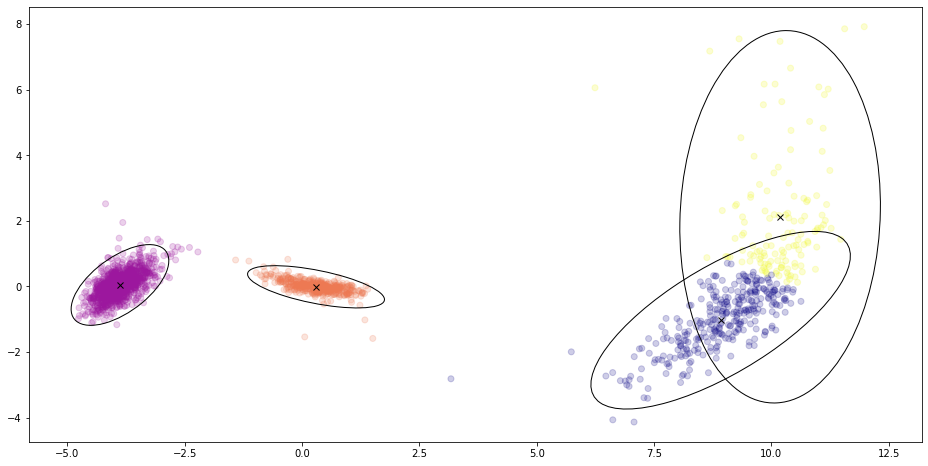

In [153]:
dims = 0, 2
dim0, dim1 = dims

fig, ax = plt.subplots()

plt.scatter(x_transformed[:, dim0], x_transformed[:, dim1], alpha=0.2, c=kmeans.labels_, cmap=cmap)

confidence_ellipse(m0, cov0, dims, ax, n_std=3, edgecolor='black')
ax.plot(m0[dim0], m0[dim1], 'x', c='black')
confidence_ellipse(m1, cov1, dims, ax, n_std=3, edgecolor='black')
ax.plot(m1[dim0], m1[dim1], 'x', c='black')
confidence_ellipse(m2, cov2, dims, ax, n_std=3, edgecolor='black')
ax.plot(m2[dim0], m2[dim1], 'x', c='black')
confidence_ellipse(m3, cov3, dims, ax, n_std=3, edgecolor='black')
ax.plot(m3[dim0], m3[dim1], 'x', c='black')

plt.show()

In [111]:
hmm = HMM(kmeans.n_clusters, 10)

In [114]:
hmm.gamma = a
hmm.delta = stat
hmm.mu = [m0, m1, m2, m3]
hmm.cov = [cov0, cov1, cov2, cov3]

In [115]:
hmm.nll(x_transformed)

1717.5307083785958

# HMM

In [355]:
class HMM:
    def __init__(self, nr_states, emission_dim):
        self.nr_states = nr_states
        self.emission_dim = emission_dim
        self.gamma = None
        self.delta = None
        self.mu = None
        self.cov = None
        
        # prepare indices of the parameters in the optimization vector thetha (see set_params_with_theta)
        i = nr_states * (nr_states - 1)
        self._theta_idx = {'gamma': range(i)}
        self._theta_idx['mu'] = [
            range(i + s * emission_dim, i + (s+1) * emission_dim) for s in range(nr_states)
        ]
        i = i + nr_states * emission_dim
        self._theta_idx['cov'] = [
            range(i + s * emission_dim * (emission_dim + 1) // 2,
                  i + (s+1) *  emission_dim * (emission_dim + 1) // 2)
            for s in range(nr_states)
        ]
        self._theta_size = i + nr_states * emission_dim * (emission_dim + 1) // 2
    
    def theta_to_params(self, theta):        
        """Translate optimization vector theta to parameters of the model
        
        The diagonal elements of gamma (transition matrix) are fixed at 1 and the rest is filled by the first
        values of theta, a softmax is done to get probabilities.
        Delta is determined by gamma
        The rest of theta stores the means and the covariance matrices of the emission distributions.
        The means are stored "verbatim".
        To make sure the covariance matrices are symmetric and positive definite we store the
        lower triangular matrix of the Cholesky decomposition of the covariance matrices
        """
        if len(theta) != self._theta_size:
            raise ValueError('Expected theta to have size {}.'.format(self._theta_size))
        
        gamma = np.eye(self.nr_states)
        gamma[gamma == 0] = theta[self._theta_idx['gamma']]
        gamma = softmax(gamma, axis=1)
        
        delta = np.linalg.solve(
            (np.eye(self.nr_states) - gamma + np.ones((self.nr_states, self.nr_states))).transpose(),
            np.ones(self.nr_states)
        )
        
        mu = [
            theta[idx] for idx in self._theta_idx['mu']
        ]
        
        cov = []
        for s in range(self.nr_states):
            cov.append(np.zeros((self.emission_dim, self.emission_dim)))
            cov[s][np.tril_indices(self.emission_dim)] = theta[self._theta_idx['cov'][s]]
            cov[s] = np.matmul(cov[s], cov[s].transpose())
            
        return gamma, delta, mu, cov
    
    def params_to_theta(self, gamma, mu, cov):
        theta = np.zeros(self._theta_size)
        
        gamma = np.log(gamma) - np.log(gamma).diagonal()[:, np.newaxis] + 1  # inverse softmax
        theta[self._theta_idx['gamma']] = gamma[~np.eye(gamma.shape[0],dtype=bool)]
        
        for s in range(self.nr_states):
            theta[self._theta_idx['mu'][s]] = mu[s]
            theta[self._theta_idx['cov'][s]] = np.linalg.cholesky(cov[s])[np.tril_indices(self.emission_dim)]
        
        return theta
    
    def get_initial_params(self, data):        
        kmeans = sklearn.cluster.KMeans(self.nr_states).fit(data)
        
        transition_count = Counter(zip(kmeans.labels_[:-1], kmeans.labels_[1:]))
        gamma = np.array([
            [transition_count[(i,j)] for j in range(kmeans.n_clusters)] for i in range(kmeans.n_clusters)
        ])
        gamma = gamma + 1  # additive smoothing
        gamma = gamma / gamma.sum(axis=1)[:, np.newaxis]
        
        delta = np.linalg.solve(
            (np.eye(self.nr_states) - gamma + np.ones((self.nr_states, self.nr_states))).transpose(),
            np.ones(self.nr_states)
        )
        
        mu = [
            data[kmeans.labels_ == s].mean(axis=0) for s in range(self.nr_states)
        ]
        
        cov = [
            np.cov(data[kmeans.labels_ == s].transpose()) for s in range(self.nr_states)
        ]
        
        return gamma, delta, mu, cov
    
    def emission_pdf(self, data, mu=None, cov=None):    
        # Returns p with p[i,s] is the propability density of the ith emission given the markov is in state s
        if mu is None:
            mu, cov = self.mu, self.cov
            
        return np.stack([
            scipy.stats.multivariate_normal(mu[s], cov[s], allow_singular=True).pdf(data)
            for s in range(self.nr_states)
        ], axis=1)
    
    def log_forward(self, data, gamma=None, delta=None, mu=None, cov=None):
        if gamma is None:
            gamma, delta, mu, cov = self.gamma, self.delta, self.mu, self.cov
        
        p = self.emission_pdf(data, mu, cov)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lalpha = np.zeros((data.shape[0], self.nr_states))
            phi = delta * p[0]
            ll = np.log(phi.sum())
            phi = phi / phi.sum()  # scale to avoid underflow
            lalpha[0] = ll + np.log(phi)
            for t in range(1, data.shape[0]):
                phi = np.dot(phi, gamma) * p[t]
                ll = ll + np.log(phi.sum())
                phi = phi / phi.sum()
                lalpha[t] = np.log(phi) + ll
        
        return lalpha
    
    def log_forward2(self, data, gamma=None, delta=None, mu=None, cov=None):
        # Mann 2006
        
        if gamma is None:
            gamma, delta, mu, cov = self.gamma, self.delta, self.mu, self.cov
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lp = np.log(self.emission_pdf(data, mu, cov))
            lg = np.log(self.gamma)
            lalpha = np.zeros((data.shape[0], self.nr_states))
            lalpha[0] = np.log(delta) + lp[0]
            for t in range(1, data.shape[0]):
                lalpha[t] = np.apply_along_axis(
                    lambda c: reduce(np.logaddexp, c), 0, lg + lalpha[t-1][:, np.newaxis]
                ) + lp[t]
        
        return lalpha
                            
    def log_backward(self, data, gamma=None, mu=None, cov=None):
        if gamma is None:
            gamma, mu, cov = self.gamma, self.mu, self.cov
        
        p = self.emission_pdf(data, mu, cov)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lbeta = np.zeros((data.shape[0], self.nr_states))
            phi = np.ones(self.nr_states) / self.nr_states
            scale = np.log(self.nr_states)
            for t in range(data.shape[0] - 2, -1, -1):
                phi = np.dot(gamma, phi * p[t + 1])
                lbeta[t] = np.log(phi) + scale
                scale = scale + np.log(phi.sum())
                phi = phi / phi.sum()    # scale to avoid underflow
        
        return lbeta
    
    def log_backward2(self, data, gamma=None, mu=None, cov=None):
        # Mann 2006
        if gamma is None:
            gamma, mu, cov = self.gamma, self.mu, self.cov
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lp = np.log(self.emission_pdf(data, mu, cov))
            lg = np.log(gamma)
            lbeta = np.zeros((data.shape[0], self.nr_states))
            for t in range(data.shape[0] - 2, -1, -1):
                lbeta[t] = np.apply_along_axis(
                    lambda c: reduce(np.logaddexp, c), 1, lg + (lbeta[t+1]+lp[t+1])[np.newaxis,:]
                )
        
        return lbeta
    
    def nll(self, data, gamma=None, delta=None, mu=None, cov=None):
        # todo functools.reduce might be faster than the for loop
        # numpy.ufunc.reduce might be even faster
        if gamma is None:
            gamma, delta, mu, cov = self.gamma, self.delta, self.mu, self.cov
        
        p = self.emission_pdf(data, mu, cov)
        forward = delta * p[0]
        if forward.sum() == 0:
            return np.inf
        ll = np.log(forward.sum())
        phi = forward / forward.sum()
        for t in range(1, data.shape[0]):
            forward = np.dot(phi, gamma) * p[t]
            if forward.sum() == 0:
                return np.inf
            ll = ll + np.log(forward.sum())
            phi = forward / forward.sum()
        return -ll
    
    def fit(self, data, method=None, maxiter=200):
        # init theta
        gamma, delta, mu, cov = self.get_initial_params(data)
        theta_0 = hmm.params_to_theta(gamma, mu, cov)
        
        # optimize nll(theta)
        def objective(theta):
            gamma, delta, mu, cov = self.theta_to_params(theta)
            return(self.nll(data, gamma, delta, mu, cov))
        
        res = scipy.optimize.minimize(objective, theta_0, method=method, options={'maxiter': maxiter})
        
        #store params
        self.gamma, self.delta, self.mu, self.cov = self.theta_to_params(res.x)
        
        return res
    
    def fit_em(self, data, maxiter=200):
        # init parameters
        gamma, delta, mu, cov = self.get_initial_params(data)
        
        nlls = []
        for i in range(maxiter):
            nll = self.nll(data, gamma, delta, mu, cov)
            nlls.append(nll)
            with np.errstate(divide='ignore'):
                lg = np.log(gamma)
                lp = np.log(self.emission_pdf(data, mu, cov))
            
            # E-Step
            
            # get forward and backwards vars
            la = self.log_forward(data, gamma, delta, mu, cov)
            lb = self.log_backward(data, gamma, mu, cov)
            
            u = np.exp(la + lb + nll)
            v = np.exp(
                la[:-1, :, np.newaxis] 
                + lg[np.newaxis, :, :] 
                + lp[1:, np.newaxis, :] 
                + lb[1:, np.newaxis, :] 
                + nll
            )
            
            
            # M-Step
            
            delta = u[0]
            gamma = v.sum(axis=0) / v.sum(axis=0).sum(axis=1)[:, np.newaxis]
            mu = (u[:, :, np.newaxis] * data[:, np.newaxis, :]).sum(axis=0) / u.sum(axis=0)[:, np.newaxis]
            cov = [np.cov(data.transpose(), aweights=u[:,s]+1e-10) for s in range(self.nr_states)]
            # todo covs are sometimes singular matrizes which is not allowed by scipy.stats.multivariate_normal
            #  but can be allowed when givig some argument, don't know if there's a catch in it...
        
        # to avoid divide by zero when using predict_states eg
        delta = delta + 1e-20
        delta = delta / delta.sum()
        gamma = gamma + 1e-20
        gamma = gamma / gamma.sum(axis=1)[:, np.newaxis]
        
        self.gamma, self.delta, self.mu, self.cov = gamma, delta, mu, cov
        nlls.append(self.nll(data, gamma, delta, mu, cov))
        return nlls
           
    def predict_states(self, data, gamma=None, delta=None, mu=None, cov=None):
        # Viterbi algorithm
        
        if gamma is None:
            gamma, delta, mu, cov = self.gamma, self.delta, self.mu, self.cov
        
        #' Viterbi algorithm
      
        #allprobs = emission_pdfs(x)
        p = self.emission_pdf(data, mu, cov)
        
        xi = np.zeros((data.shape[0], self.nr_states))
        xi[0] = delta * p[0] / np.dot(delta, p[0])
        for t in range(1, data.shape[0]):
            xi[t] = np.dot(xi[t - 1], gamma).max() * p[t,]
            xi[t] = xi[t] / xi[t].sum()
            
        iv = np.zeros(data.shape[0], dtype=np.uint8)
        iv[-1] = xi[-1].argmax()
        for t in range(data.shape[0] - 2, -1, -1):
            iv[t] = (gamma[:, iv[t + 1]] * xi[t]).argmax()
        
        return iv
    
    def pseudo_residuals(self, data):
        pass

## Tests

In [114]:
#record_nr = 115
#record_nr = 122
record_nr = 119

record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[np.logical_or(symbols == 'N', symbols == 'V')]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align
mean = data.mean(axis=0)
x = data - mean
pca = sklearn.decomposition.PCA(4)
x_transformed = pca.fit_transform(x)

In [115]:
hmm = HMM(3, x_transformed.shape[1])

In [116]:
hmm._theta_idx

{'gamma': range(0, 6),
 'mu': [range(6, 10), range(10, 14), range(14, 18)],
 'cov': [range(18, 28), range(28, 38), range(38, 48)]}

In [117]:
hmm._theta_size

48

In [118]:
#theta = np.arange(hmm._theta_size)
#g, d, m, c = hmm.theta_to_params(theta)

#theta = np.random.rand(hmm._theta_size)
#g, d, m, c = hmm.theta_to_params(theta)

g, d, m, c = hmm.get_initial_params(x_transformed)
theta = hmm.params_to_theta(g, m, c)

hmm.gamma, hmm.delta, hmm.mu, hmm.cov = g, d, m, c
g, d, m , c

(array([[2.23713647e-03, 6.17449664e-01, 3.80313199e-01],
        [9.09090909e-04, 7.49090909e-01, 2.50000000e-01],
        [9.95525727e-01, 2.23713647e-03, 2.23713647e-03]]),
 array([0.22372576, 0.55255031, 0.22372394]),
 [array([ 9.29086473e+00, -2.46553515e+00, -1.05124617e-01, -5.81090049e-03]),
  array([-3.87798807e+00, -2.13430881e+00,  4.63807536e-02, -1.14762835e-03]),
  array([ 0.29929495,  7.74362315, -0.00957373,  0.00864895])],
 [array([[ 1.0807954 , -0.12042013,  1.27903655,  0.47768076],
         [-0.12042013,  0.22914093,  0.01789716, -0.04041188],
         [ 1.27903655,  0.01789716,  3.67909823,  0.65536778],
         [ 0.47768076, -0.04041188,  0.65536778,  0.3575626 ]]),
  array([[ 0.12032979,  0.0545571 ,  0.08532658, -0.1856196 ],
         [ 0.0545571 ,  0.10886974,  0.04557263, -0.06104272],
         [ 0.08532658,  0.04557263,  0.16818139, -0.260883  ],
         [-0.1856196 , -0.06104272, -0.260883  ,  0.50639285]]),
  array([[ 0.23645223,  0.10655753, -0.06275253,

In [119]:
assert np.allclose(theta, hmm.params_to_theta(g, m, c))

In [120]:
# stationary distribution
assert np.allclose(d, np.dot(d, g)) and np.allclose(d, np.dot(np.dot(d, g), g))

In [121]:
p = hmm.emission_pdf(x_transformed)
p.shape

(1986, 3)

In [122]:
hmm.nll(x_transformed)

4267.473844699064

In [123]:
# forward and backward variables
a = hmm.log_forward(x_transformed)
a2 = hmm.log_forward2(x_transformed)
b = hmm.log_backward(x_transformed)
b2 = hmm.log_backward2(x_transformed)
t = 456

In [124]:
assert np.allclose(-reduce(np.logaddexp, a[t] + b[t]), hmm.nll(x_transformed))

In [125]:
assert np.allclose(-reduce(np.logaddexp, a2[t] + b2[t]), hmm.nll(x_transformed))

In [126]:
print(-hmm.nll(x_transformed))
print(a[t], '\n', b[t], '\n', reduce(np.logaddexp, a[t] + b[t]))
print(a2[t], '\n', b2[t], '\n', reduce(np.logaddexp, a2[t] + b2[t]))

-4267.473844699064
[-1080.79571447  -867.42765484 -1125.03438728] 
 [-3400.23945266 -3400.04618986 -3405.85985353] 
 -4267.47384469906
[-1080.79571447  -867.42765484 -1125.03438728] 
 [-3400.23945266 -3400.04618986 -3405.85985353] 
 -4267.473844699134


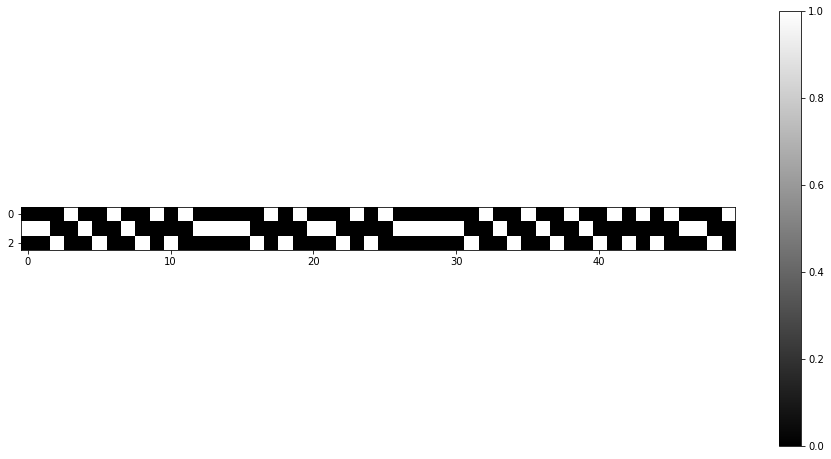

In [127]:
# conditional probabilities of states
u = np.exp(a2 + b2 + hmm.nll(x_transformed))
plt.imshow(u[800:850].transpose(), vmin=0, vmax=1, cmap='gray')
plt.colorbar()

In [128]:
# cond prob of transitions
v = np.exp(
    a2[:-1, :, np.newaxis] 
    + np.log(hmm.gamma)[np.newaxis, :, :] 
    + np.log(p)[1:, np.newaxis, :] 
    + b2[1:, np.newaxis, :] 
    + hmm.nll(x_transformed)
)

/tmp/ipykernel_3110/4236796981.py:5: RuntimeWarning: divide by zero encountered in log
  + np.log(p)[1:, np.newaxis, :]


In [129]:
assert np.allclose(v.sum(axis=1).sum(axis=1), 1)

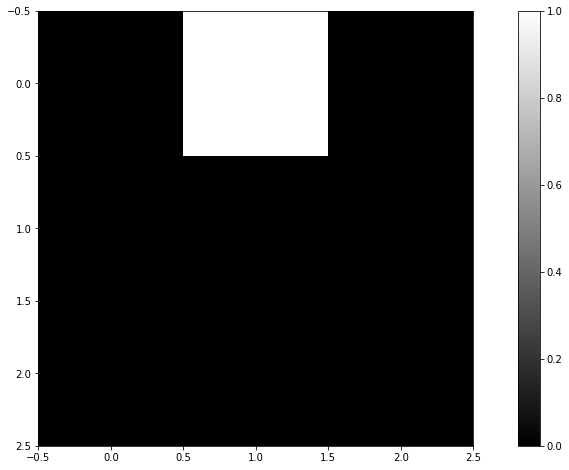

In [130]:
t = 835
plt.imshow(v[t], vmin=0, vmax=1, cmap='gray')
plt.colorbar()

In [131]:
# M-Step Approximations
# u[0] is the non stationary approximation, hmm.delta assumes stationarity
u[0], hmm.delta

(array([3.41405091e-117, 1.54395009e-209, 1.00000000e+000]),
 array([0.22372576, 0.55255031, 0.22372394]))

In [132]:
v.sum(axis=0) / v.sum(axis=0).sum(axis=1)[:, np.newaxis], hmm.gamma

(array([[8.69101681e-55, 6.19369369e-01, 3.80630631e-01],
        [1.87045431e-63, 7.50227894e-01, 2.49772106e-01],
        [1.00000000e+00, 4.54183709e-48, 1.25279920e-43]]),
 array([[2.23713647e-03, 6.17449664e-01, 3.80313199e-01],
        [9.09090909e-04, 7.49090909e-01, 2.50000000e-01],
        [9.95525727e-01, 2.23713647e-03, 2.23713647e-03]]))

In [133]:
m_hat = (u[:, :, np.newaxis] * x_transformed[:, np.newaxis, :]).sum(axis=0) / u.sum(axis=0)[:,np.newaxis]
m_hat, hmm.mu

(array([[ 9.29086473e+00, -2.46553515e+00, -1.05124617e-01,
         -5.81090049e-03],
        [-3.87798807e+00, -2.13430881e+00,  4.63807536e-02,
         -1.14762835e-03],
        [ 2.99294949e-01,  7.74362315e+00, -9.57373368e-03,
          8.64895438e-03]]),
 [array([ 9.29086473e+00, -2.46553515e+00, -1.05124617e-01, -5.81090049e-03]),
  array([-3.87798807e+00, -2.13430881e+00,  4.63807536e-02, -1.14762835e-03]),
  array([ 0.29929495,  7.74362315, -0.00957373,  0.00864895])])

In [134]:
[np.cov(x_transformed.transpose(), aweights=u[:,s]) for s in range(hmm.nr_states)], hmm.cov

([array([[ 1.0807954 , -0.12042013,  1.27903655,  0.47768076],
         [-0.12042013,  0.22914093,  0.01789716, -0.04041188],
         [ 1.27903655,  0.01789716,  3.67909823,  0.65536778],
         [ 0.47768076, -0.04041188,  0.65536778,  0.3575626 ]]),
  array([[ 0.12032979,  0.0545571 ,  0.08532658, -0.1856196 ],
         [ 0.0545571 ,  0.10886974,  0.04557263, -0.06104272],
         [ 0.08532658,  0.04557263,  0.16818139, -0.260883  ],
         [-0.1856196 , -0.06104272, -0.260883  ,  0.50639285]]),
  array([[ 0.23645223,  0.10655753, -0.06275253,  0.02245362],
         [ 0.10655753,  0.35960216, -0.07086507,  0.10401613],
         [-0.06275253, -0.07086507,  0.04606436, -0.00974106],
         [ 0.02245362,  0.10401613, -0.00974106,  0.11834833]])],
 [array([[ 1.0807954 , -0.12042013,  1.27903655,  0.47768076],
         [-0.12042013,  0.22914093,  0.01789716, -0.04041188],
         [ 1.27903655,  0.01789716,  3.67909823,  0.65536778],
         [ 0.47768076, -0.04041188,  0.65536778,

In [135]:
# FITTING

In [136]:
t0 = time.time()
nlls = hmm.fit_em(x_transformed)
print('Time to fit:', time.time() - t0)
print('Final nll:', nlls[-1])

Time to fit: 15.162271499633789
Final nll: 4261.992464085523


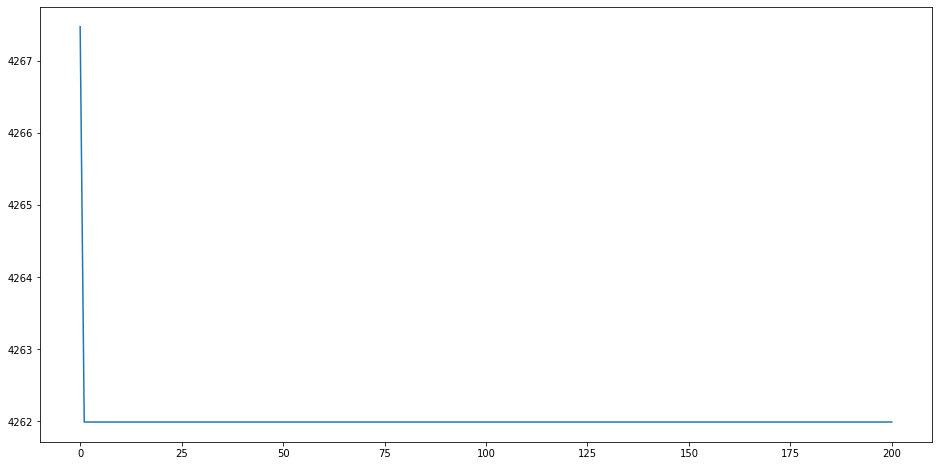

In [139]:
plt.plot(nlls)

In [105]:
t0 = time.time()
res = hmm.fit(x_transformed, method='BFGS')
print('Time to fit:', time.time() - t0)
print('Minimal nll:', res.fun)
print('Success', res.success)
print('Message:', res.message)

/home/arne/Code/functional_data_hmm/venv/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Time to fit: 136.21481585502625
Minimal nll: 4263.4859504098295
Success False
Message: Desired error not necessarily achieved due to precision loss.


Initial nll (k-means):
- 5362

Some results (all maxiter 200):
- Nelder-Mead: 9, 5361, no success
- Powell: 43, 5359, success
- CG: 459, 5360, no success
- BFGS: 189, 5358, no success
- L-BFGS-B: 3, 5362, success
- TNC: 301, 5361, no success
- COBYLA: 5, 5360, no success
- SLSQP: error due to singular matrix
- trust-constr: 12, 5362, no success

array([[7.49852578e-01, 1.26131849e-10, 2.50147422e-01],
       [6.18895046e-01, 1.27589667e-09, 3.81104952e-01],
       [5.94261537e-11, 9.99999999e-01, 7.28763070e-10]])

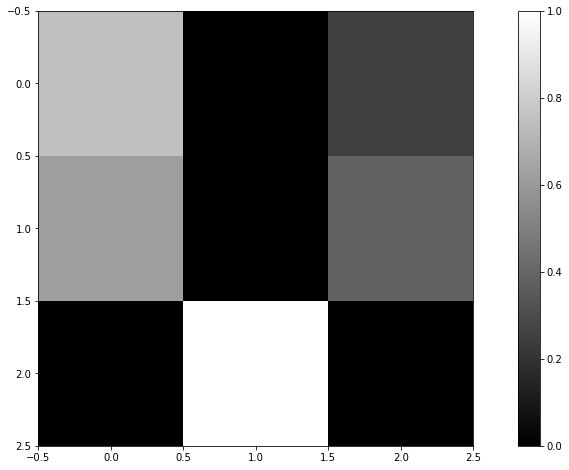

In [106]:
plt.imshow(hmm.gamma, vmin=0, vmax=1, cmap='gray')
plt.colorbar()
hmm.gamma

In [96]:
hmm.delta

array([0., 0., 1., 0.])

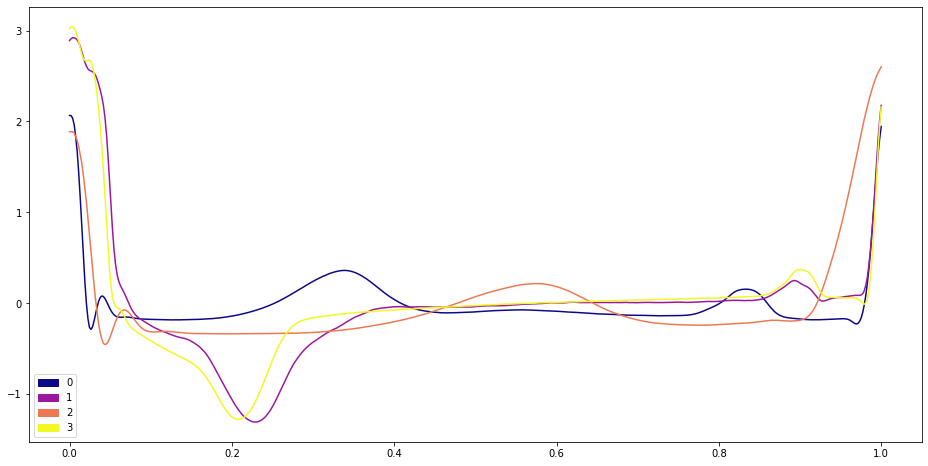

In [97]:
cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
for s in range(hmm.nr_states):
    plt.plot(np.linspace(0, 1, data.shape[1]), np.dot(hmm.mu[s], pca.components_) + mean, color=cmap(s))
plt.legend([Patch(color=cmap(s)) for s in range(hmm.nr_states)], range(hmm.nr_states))
pass

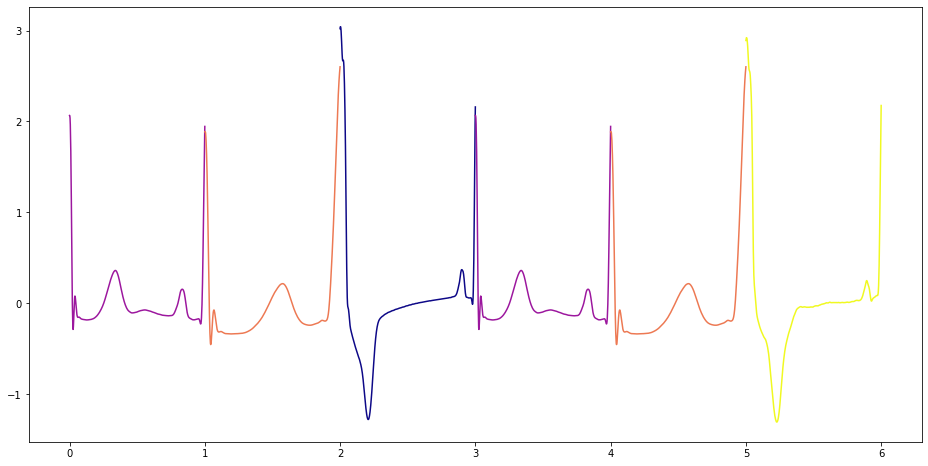

In [30]:
plt.plot(np.linspace(0, 1, data.shape[1]), np.dot(hmm.mu[1], pca.components_) + mean, color=cmap(1))
plt.plot(np.linspace(0, 1, data.shape[1])+1, np.dot(hmm.mu[2], pca.components_) + mean, color=cmap(2))
plt.plot(np.linspace(0, 1, data.shape[1])+2, np.dot(hmm.mu[0], pca.components_) + mean, color=cmap(0))
plt.plot(np.linspace(0, 1, data.shape[1])+3, np.dot(hmm.mu[1], pca.components_) + mean, color=cmap(1))
plt.plot(np.linspace(0, 1, data.shape[1])+4, np.dot(hmm.mu[2], pca.components_) + mean, color=cmap(2))
plt.plot(np.linspace(0, 1, data.shape[1])+5, np.dot(hmm.mu[3], pca.components_) + mean, color=cmap(3))

In [98]:
states = hmm.predict_states(x_transformed)

In [99]:
[(states == s).sum() / x_transformed.shape[0] for s in range(hmm.nr_states)], hmm.delta

([0.552870090634441,
  0.02769385699899295,
  0.22356495468277945,
  0.1958710976837865],
 array([0., 0., 1., 0.]))

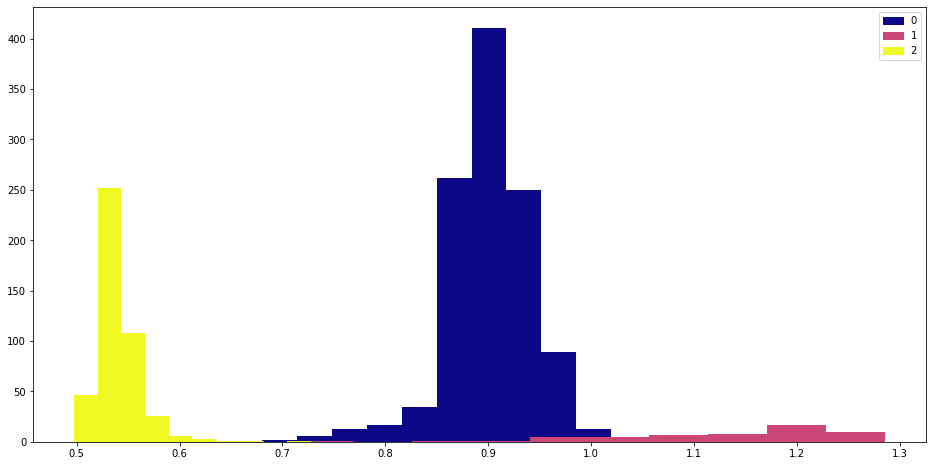

In [112]:
cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
for s in range(hmm.nr_states):
    plt.hist(periods[states == s], color=cmap(s))
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))
pass

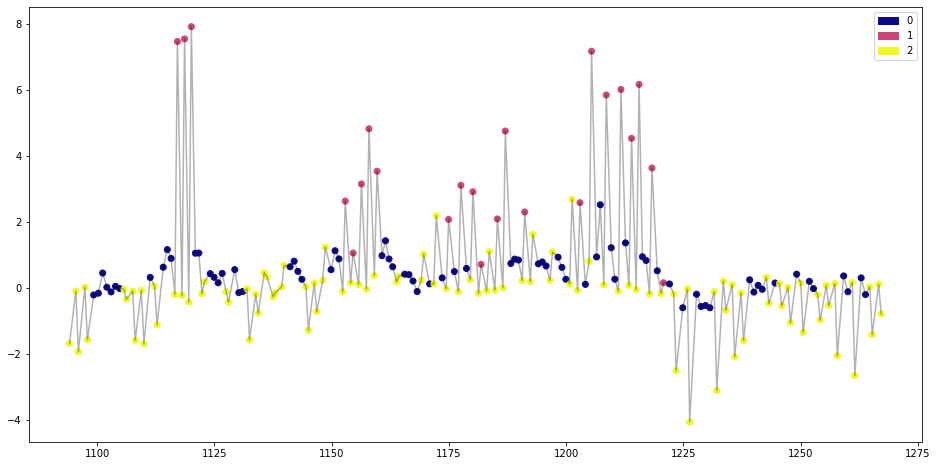

In [111]:
start, stop = 400, 700
start, stop = 800, 1000
start, stop = 1200, 1400
dim = 2

cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
plt.plot(cuts[:-1][start:stop] / record.fs, x_transformed[:,dim][start:stop], color='black', alpha=0.3)
plt.scatter(
    cuts[:-1][start:stop] / record.fs, 
    x_transformed[:,dim][start:stop], 
    c=states[start:stop],
    cmap=cmap
)
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))

## Application

In [198]:
#record_nr = 115
#record_nr = 122
record_nr = 119
record_nr = 100
record_nr = 232


record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[(symbols == 'A') | (symbols == 'N') | (symbols == 'R') | (symbols == 'V')]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data = (data - data.sum(axis=1)[:, None]/max_data_len)  # vertical align
mean = data.mean(axis=0)
x = data - mean
pca = sklearn.decomposition.PCA(15)
x_transformed = pca.fit_transform(x)

In [199]:
hmm = HMM(3, x_transformed.shape[1])

In [200]:
t0 = time.time()
nlls = hmm.fit_em(x_transformed, maxiter=50)
print('Time to fit:', time.time() - t0)
print('Final nll:', nlls[-1])

Time to fit: 12.576292276382446
Final nll: 7688.202576189917


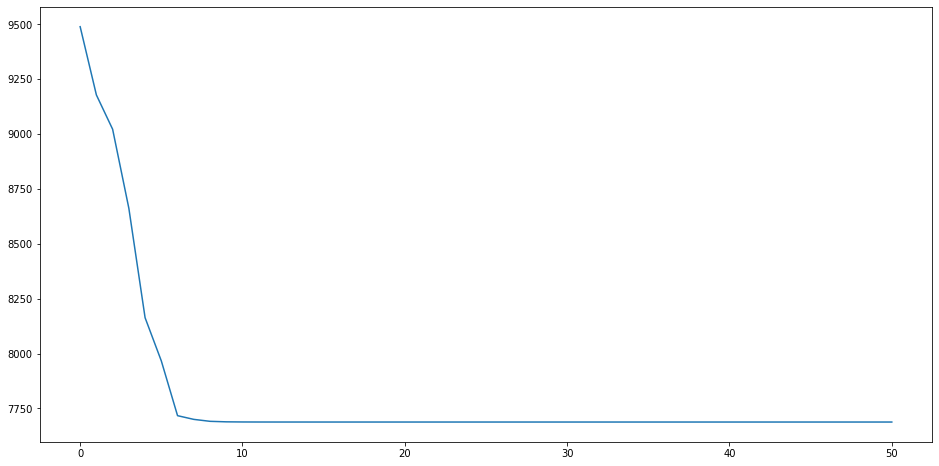

In [201]:
plt.plot(nlls)

array([[3.02267003e-01, 6.97732997e-01, 1.00000000e-20],
       [8.96717650e-02, 2.22958807e-01, 6.87369428e-01],
       [2.45762364e-01, 3.20087654e-02, 7.22228870e-01]])

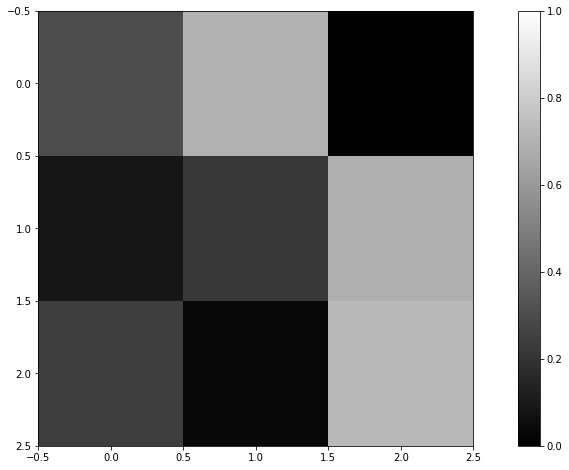

In [202]:
plt.imshow(hmm.gamma, vmin=0, vmax=1, cmap='gray')
plt.colorbar()
hmm.gamma

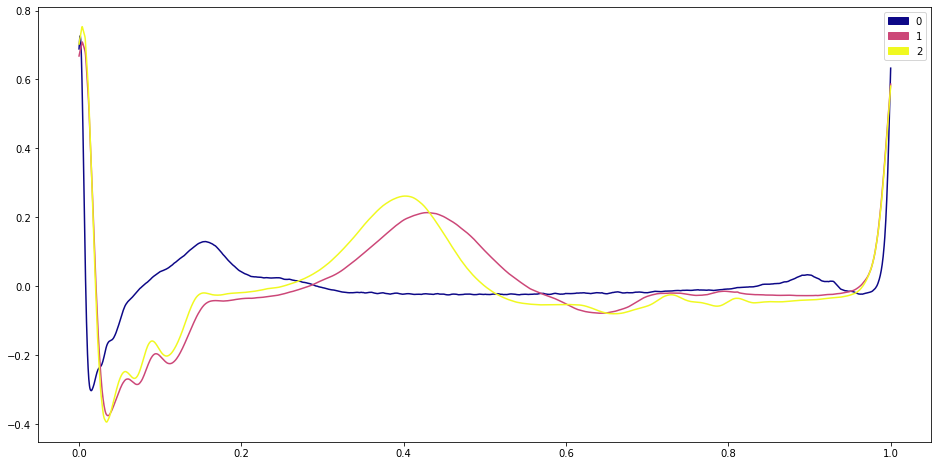

In [203]:
cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
for s in range(hmm.nr_states):
    plt.plot(np.linspace(0, 1, data.shape[1]), np.dot(hmm.mu[s], pca.components_) + mean, color=cmap(s))
plt.legend([Patch(color=cmap(s)) for s in range(hmm.nr_states)], range(hmm.nr_states))
pass

In [204]:
states = hmm.predict_states(x_transformed)

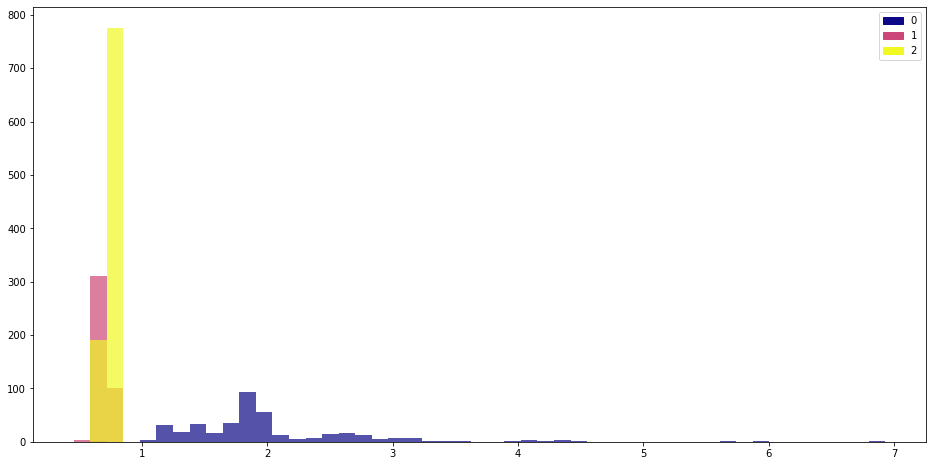

In [205]:
cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
bins = np.linspace(min(periods), max(periods), 50)
for s in range(hmm.nr_states):
    plt.hist(periods[states == s], bins=bins, color=cmap(s), alpha=0.7)
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))
pass

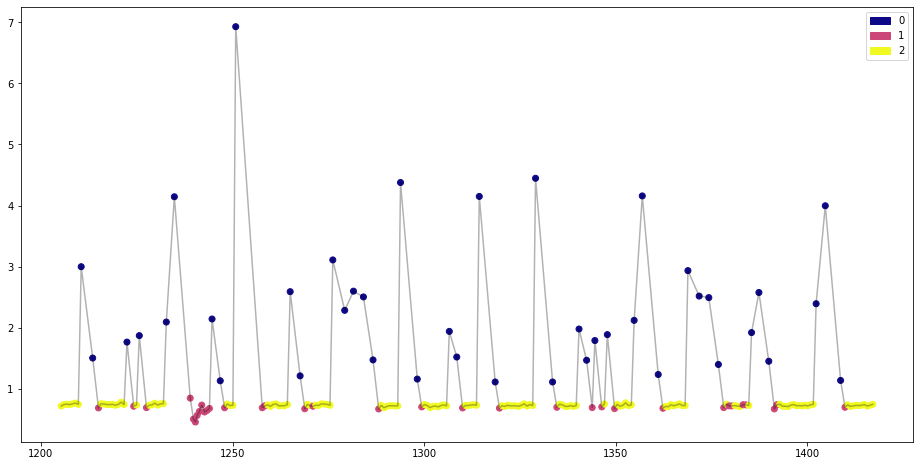

In [206]:
start, stop = 400, 700
start, stop = 800, 1000
start, stop = 1200, 1400
dim = 0

cmap = plt.cm.get_cmap('plasma', hmm.nr_states)
plt.plot(
    cuts[:-1][start:stop] / record.fs, 
    #x_transformed[:,dim][start:stop],
    periods[start:stop],
    color='black', alpha=0.3
)
plt.scatter(
    cuts[:-1][start:stop] / record.fs, 
    #x_transformed[:,dim][start:stop],
    periods[start:stop],
    c=states[start:stop],
    cmap=cmap
)
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))

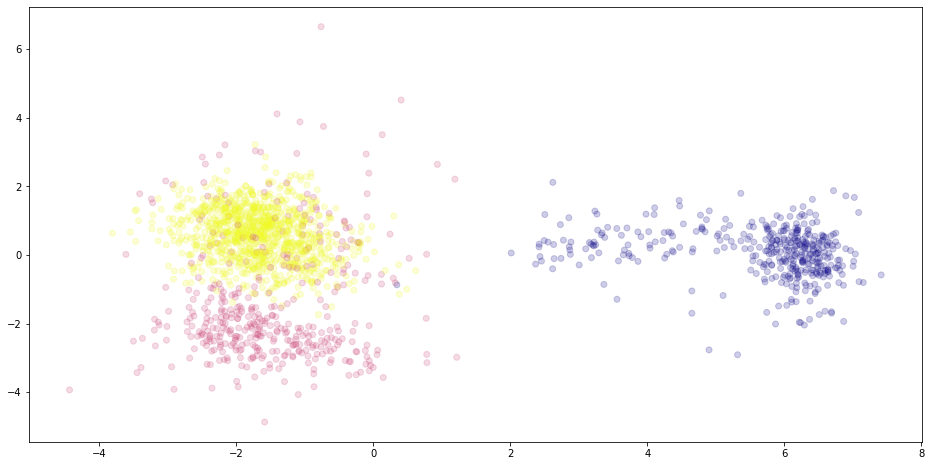

In [207]:
plt.scatter(x_transformed[:, 0], x_transformed[:, 1], alpha=0.2, c=states, cmap=cmap)

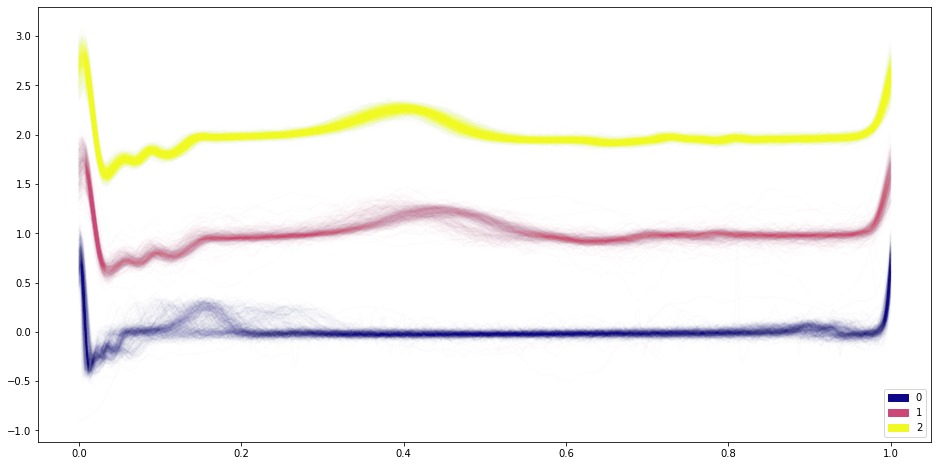

In [208]:
t = np.linspace(0, 1, data.shape[1])

for s in range(hmm.nr_states):    
    plt.plot(t, data[states == s].transpose()+s, color=cmap(s), alpha=0.01)

plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))
pass

# Model both channels and period length

In [343]:
#record_nr = 115
#record_nr = 122
#record_nr = 119
#record_nr = 100
record_nr = 232
record_nr = 200


record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr))
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/{}'.format(record_nr), 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)
cuts = annotation.sample[(symbols == 'A') | (symbols == 'N') | (symbols == 'R') | (symbols == 'V')]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])

data_0 = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0])
    for i in range(len(cuts)-1)
])
data_0 = (data_0 - data_0.sum(axis=1)[:, None]/max_data_len)  # vertical align

data_1 = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len), 
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 1])
    for i in range(len(cuts)-1)
])
data_1 = (data_1 - data_1.sum(axis=1)[:, None]/max_data_len)  # vertical align

data = np.concatenate((data_0, data_1, periods[:, np.newaxis]), axis=1)

pca = sklearn.decomposition.PCA()
data_pca = pca.fit_transform(data)

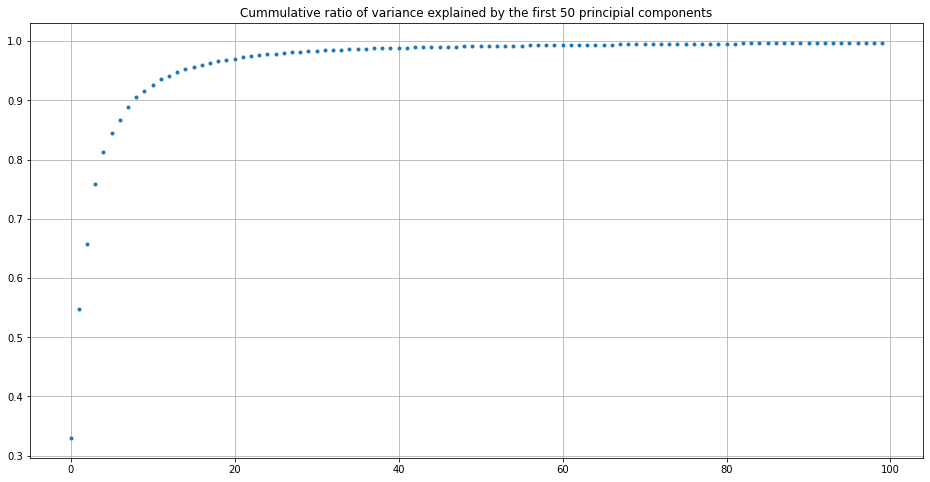

In [344]:
plt.plot(pca.explained_variance_ratio_.cumsum()[:100], '.')
plt.grid()
plt.title('Cummulative ratio of variance explained by the first 50 principial components')
pass

## project PCs back into the original space

In [345]:
pca_dim = 100
data_approx = pca.mean_ + np.matmul(data_pca[:,:pca_dim], pca.components_[:pca_dim])
data_0_approx = data_approx[:, :max_data_len]
data_1_approx = data_approx[:, max_data_len:2 * max_data_len]
periods_approx = data_approx[:, -1]

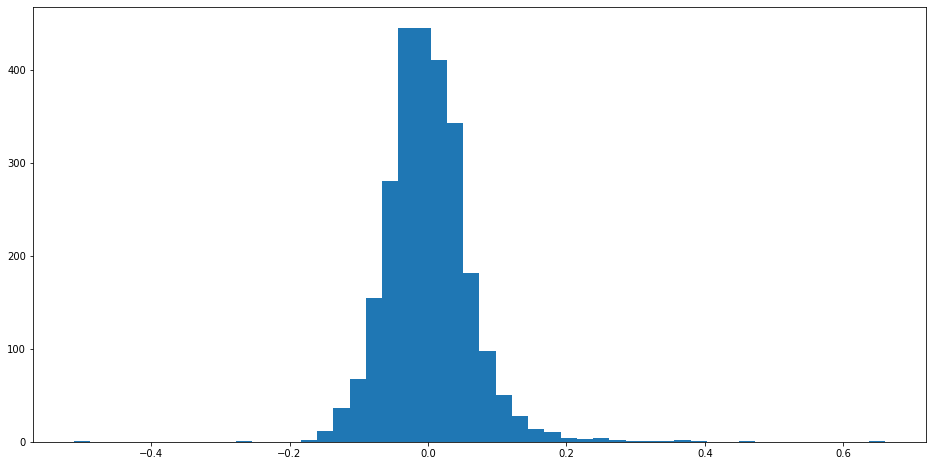

In [346]:
plt.hist(periods - periods_approx, 50)
pass

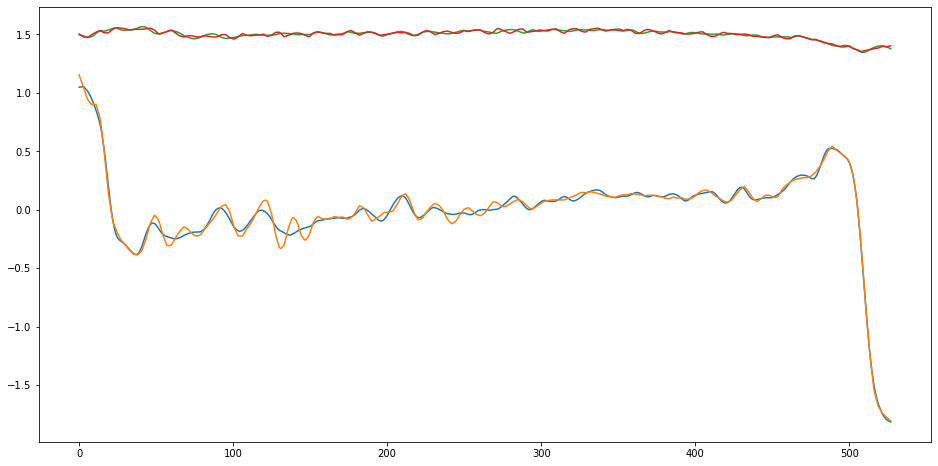

In [347]:
plt.plot(data_0_approx[123])
plt.plot(data_0[123])

plt.plot(data_1_approx[123]+1.5)
plt.plot(data_1[123]+1.5)

## Fit HMM

In [376]:
hmm = HMM(6, pca_dim)
t0 = time.time()
nlls = hmm.fit_em(data_pca[:,:pca_dim], maxiter=50)
print('Time to fit:', time.time() - t0)
print('Final nll:', nlls[-1])

Time to fit: 27.94241166114807
Final nll: -227840.63934160603


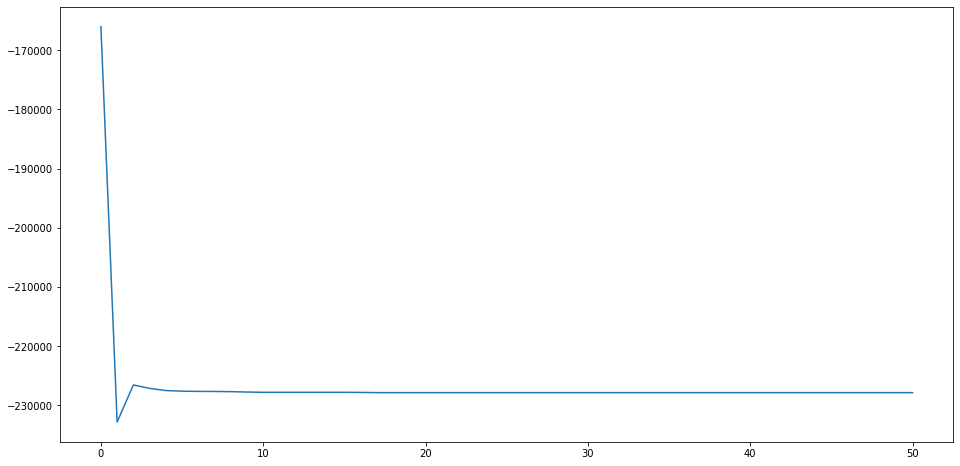

In [377]:
plt.plot(nlls)

In [378]:
states = hmm.predict_states(data_pca[:,:pca_dim])
{s: (states == s).sum() for s in states}

{2: 676, 1: 678, 0: 1012, 5: 183, 3: 24, 4: 25}

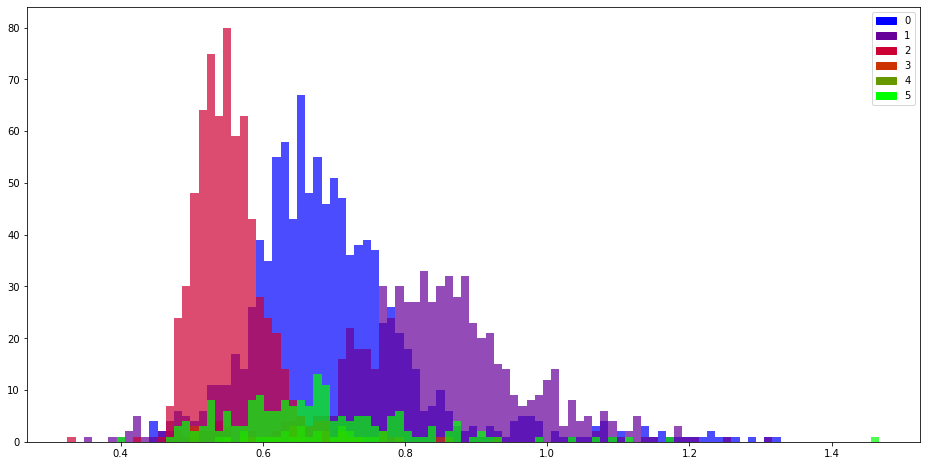

In [401]:
cmap = plt.cm.get_cmap('brg', hmm.nr_states)
bins = np.linspace(min(periods), max(periods), 100)
for s in range(hmm.nr_states):
    plt.hist(periods[states == s], bins=bins, color=cmap(s), alpha=0.7)
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))
pass

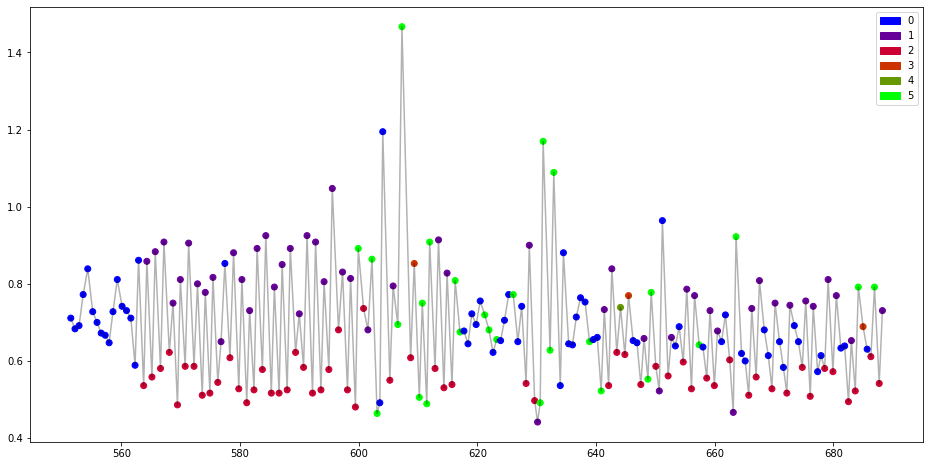

In [405]:
start, stop = 400, 700
start, stop = 800, 1000
#start, stop = 1200, 1400
dim = 1

cmap = plt.cm.get_cmap('brg', hmm.nr_states)
plt.plot(
    cuts[:-1][start:stop] / record.fs, 
    #x_transformed[:,dim][start:stop],
    periods[start:stop],
    color='black', alpha=0.3
)
plt.scatter(
    cuts[:-1][start:stop] / record.fs, 
    #x_transformed[:,dim][start:stop],
    periods[start:stop],
    c=states[start:stop],
    cmap=cmap
)
plt.legend([Patch(color=cmap(c)) for c in range(hmm.nr_states)], range(hmm.nr_states))

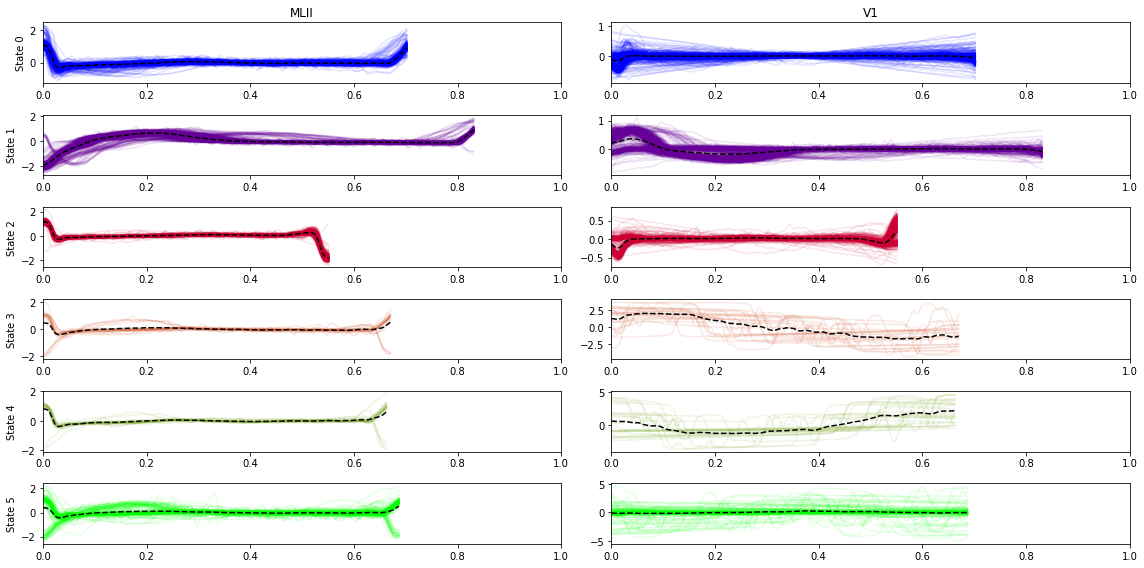

In [408]:
fig, axs = plt.subplots(hmm.nr_states, 2)
axs[0,0].set_title(record.sig_name[0])
axs[0,1].set_title(record.sig_name[1])
t_lim = 1
for s in range(hmm.nr_states):
    mu_pca = hmm.mu[s]
    mu = pca.mean_ + np.matmul(mu_pca, pca.components_[:pca_dim])
    mu_0 = mu[:max_data_len]
    mu_1 = mu[max_data_len:2*max_data_len]
    mu_period = mu[-1]
    t = np.linspace(0, mu_period, max_data_len)
    axs[s,0].plot(t, data_0[states == s].transpose(), color=cmap(s), alpha=0.1)
    axs[s,1].plot(t, data_1[states == s].transpose(), color=cmap(s), alpha=0.1)
    axs[s,0].plot(t, mu_0, '--', color='black')
    axs[s,1].plot(t, mu_1, '--', color='black')
    axs[s,0].set_xlim(0, t_lim)
    axs[s,1].set_xlim(0, t_lim)
    axs[s,0].set_ylabel('State {}'.format(s))
plt.tight_layout()
#fig.savefig('exemple.png', facecolor=(0.8,0.8,0.8), edgecolor='none')

# TODO

- Use a functional basis instead of linear resampling.
- Use a normal ECG baseline wander remove technique.
- I have yet to find something with HMMs that is not already clear from the simpler methods (k-means).
- Look at completely different data.
- Second order HMM
- Make a moving average beats per minute a covariate of the shape in addition to the hidden states
- detect classifications with high uncertainty
- ...